# Circular Statistics

## Packages

We import all relevant packages.

In [1]:
#Import relevant packages
import csv
import math
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Circular Module

This module performs the procedure to calculate the circular statistics for each spider and a graph with raster plot on the left panel and circular plot on the right panel will be generated for each spider.

In [2]:
class Circular:
    
    def __init__(self, period=24., nbins=36):
        self.period=period
        self.nbins=nbins
        self.binwidth = self.period/self.nbins
        self.binwidth_radians = 2. * np.pi/self.nbins
        self.binwidth_degrees =       360./self.nbins
        
    #----------------------------------
    #    Convert degrees to radians
    #----------------------------------
    def Degrees_to_Radians(self, degree):
        return degree/180.*np.pi

    #----------------------------------
    #    Convert radians to degrees
    #----------------------------------
    def Radians_to_Degree(self, radians):
        return radians/np.pi*180.

    #----------------------------------
    #    Convert hours to minutes
    #----------------------------------
    def to_min(self, hours):
        return(hours*60.)

    #----------------------------------
    # Label the axis according to the period
    #----------------------------------
    def axis_labels(self, nbins):
        degrees_list = np.linspace(0, 360, nbins+1)
        hours_list   = np.linspace(0, self.period, nbins+1)
        hours_pretty = hours_list.round(1)
        # Do not return last label to avoid double-labeling zero poing
        return(degrees_list, hours_pretty[:-1]) 

    #----------------------------------
    # Find the maximum position of the autocorrelation data
    #----------------------------------
    def max_position(self, data):
        threshold=600
        maxp=0
        maxv=0
        i=0
        for d in data[threshold:]:
            if d>maxv:
                maxv=d
                maxp=i+threshold
            i=i+1
        return maxp, maxv

    #----------------------------------
    # Load the spider data
    #----------------------------------
    def load_data(self, filename):
        #Read in the data
        self.df_full = pd.read_csv(filename, index_col=0)
        self.df_full.index = pd.to_datetime(self.df_full.index)

    #----------------------------------
    # Get the period of the spider according to the autocorrelation
    #----------------------------------
    def get_period_by_acf(self, spider_col):
        hours=36
        lag=self.to_min(hours)
        ACF_data=acf(self.df_full[spider_col], nlags=lag, fft=False)
        maxp, maxv=self.max_position(ACF_data)
        self.period=maxp/60
    
    #----------------------------------
    # Resample the data according to the number of bins defined
    #----------------------------------
    def groupby_bins(self, spider):
        period_min=int(self.to_min(self.period))
        efflen=len(self.df_full)//period_min*period_min
        df = self.df_full[0:efflen].copy()
        # Add column which contains bin number(phase)
        df['bin_number']= np.arange(0, len(df))*self.nbins//period_min%self.nbins
        self.df_bins = df.groupby('bin_number').sum()
        self.df_bins[spider]=self.df_bins[spider]/np.sum(self.df_bins[spider])
        
    #----------------------------------
    # Calculate the mean direction of the spider
    #----------------------------------
    def mean_direction(self, spider_col):
        self.df_bins['x'] = np.cos(self.df_bins.index*self.binwidth_radians)
        self.df_bins['y'] = np.sin(self.df_bins.index*self.binwidth_radians)
        x_total = np.sum(self.df_bins.x*self.df_bins[spider_col])
        y_total = np.sum(self.df_bins.y*self.df_bins[spider_col])
        self.r_total = np.sqrt(x_total**2 + y_total**2)
        x_avg = x_total/self.r_total
        y_avg = y_total/self.r_total
        #theta: mean direction
        #change radian to degree
        if x_total<0:
            if y_total>0:
                self.theta_avg = self.Radians_to_Degree(np.arctan(y_avg/x_avg)+np.pi)
            else:
                self.theta_avg = self.Radians_to_Degree(np.arctan(y_avg/x_avg)-np.pi)
        else:
            self.theta_avg = self.Radians_to_Degree(np.arctan(y_avg/x_avg))

    #----------------------------------
    # Plot raster plot for the spider in left panel
    #----------------------------------
    def plot_raster(self, Spider, gs):
        one_day=60*24

        #The number of days included in the RasterData
        number_of_days=int(len(self.df_full)/one_day)

        #Loop through days and plot daily activity as a subplot 
        for i in range(0,number_of_days):

            #Separate the RasterData in the length of one day
            data=pd.DataFrame(self.df_full.iloc[0+i*one_day:one_day+i*one_day])

            #Share the subplots in the left panel with the same x-axis 
            if i==0:
                ax1=plt.subplot(gs[i,0])
                ax0=ax1
            else:
                ax1=plt.subplot(gs[i,0],sharex=ax0)
            if i<number_of_days-1:
                plt.setp(ax1.get_xticklabels(), visible=False)

            #Plot the raster plot
            ax1.plot(data.Time,data[Spider])

            #Set the date as y-axis labe
            #ax1.set_ylabel(data.Date[1])
            ax1.set_ylabel(i+1, fontsize=14)

            #Indicate the dark portion of the day by gray shading
            light=True
            for t in data.index:
                if data.lights[t]==0:
                    if light:
                        light=False
                        start=t
                else:
                    if not light:
                        light=True
                        ax1.axvspan(data.Time[start],data.Time[t], alpha=0.3, color='gray')
            if not light:
                ax1.axvspan(data.Time[start],data.Time[t], alpha=0.3, color='gray')

        #The number of ticks in x-axis and the length between each point
        number_of_points=6
        len_between_points=24*60/number_of_points

        #Define the range of the x-axis and change the number of ticks on x-axis
        plt.xticks(range(0,int(one_day)+1,int(len_between_points)), range(0,int(one_day/60)+1,int(len_between_points/60)), fontsize=14)
        plt.xlim(0,one_day)
        
        plt.tight_layout()
        
    #----------------------------------
    # Plot circular plot for the spider in right panel
    #----------------------------------
    def plot_circular(self, spider_col, ax):
        #Color of the bars
        radii = 10 * np.random.rand(self.nbins)
        colors = plt.cm.viridis(radii/10.)
        #Get the angle in radians(*theta*) for all bins
        theta = self.df_bins.index*self.binwidth_radians
        #Plot the bar plot with polar coordinate
        ax.bar(theta, self.df_bins[spider_col], width=self.binwidth_radians, bottom=0.0, color=colors, alpha=0.5)
        #Plot the mean direction normalized by a number of bins
        ax.plot([0,self.Degrees_to_Radians(self.theta_avg)], [0,self.r_total/self.nbins], color='red',linewidth=3)
        
        #Re-label the axis with hours instead of degrees using *nlabels* labeling points
        nlabels = 8
        [deg, hours] = self.axis_labels(nlabels)
        ax.set_thetagrids(deg, hours, fontsize=15)
        ax.set_title(spider_col, fontsize=17)
        #plt.yticks([0.02, 0.04, 0.06, 0.08])
        
        #Set the range of the radius of circular plot (Modify according to the range of each spider's circular plot)
        #ax.set_rlim(0,0.12)
        plt.show()
        
    #----------------------------------
    # Run the process
    #----------------------------------        
    def run(self, filename, spider_col, p):
        self.load_data(filename)
        #Calculate the circadian period by autocorrelation for DD period
        #self.get_period_by_acf(spider_col)
        self.period=p
        self.groupby_bins(spider_col)
        self.mean_direction(spider_col)
        
    def run_plot(self, spider):
        fig = plt.figure(figsize=(17, 8))
        gs=GridSpec(9, 2, figure=fig)
        self.plot_raster(spider, gs)
        ax = plt.subplot(gs[0:-1,1], projection='polar')
        self.plot_circular(spider, ax)

## Get circadian period for DD from Lomb-Scargle Periodogram

We read in the data file containing the circadian periods calculated by Lomb-Scargle Periodogram and corresponding p-value for each spider. This data file is the output file after running the `LS_Period.ipynb` Jupyter Notebook document.

In [17]:
#Dataframe containing DD period calculated by periodogram and corresponding p-value
df_period=pd.read_csv('Para_DD_Stats.csv', index_col=0)
#This is the list containing the index of the spider
s=df_period.index.tolist()

print(s)
df_period.head()

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's27', 's29', 's30', 's31', 's32']


Period    Amplitude        p value
Spider                                       
s1      21.833147    95.500000   1.085111e-36
s2      21.701522  3393.873060   0.000000e+00
s3      21.485639   943.961688   0.000000e+00
s4      22.422469   285.728843  4.551056e-119
s5      20.623953     8.212159   1.000000e+00

## LD Period

Here we perform the whole procedure for LD period.

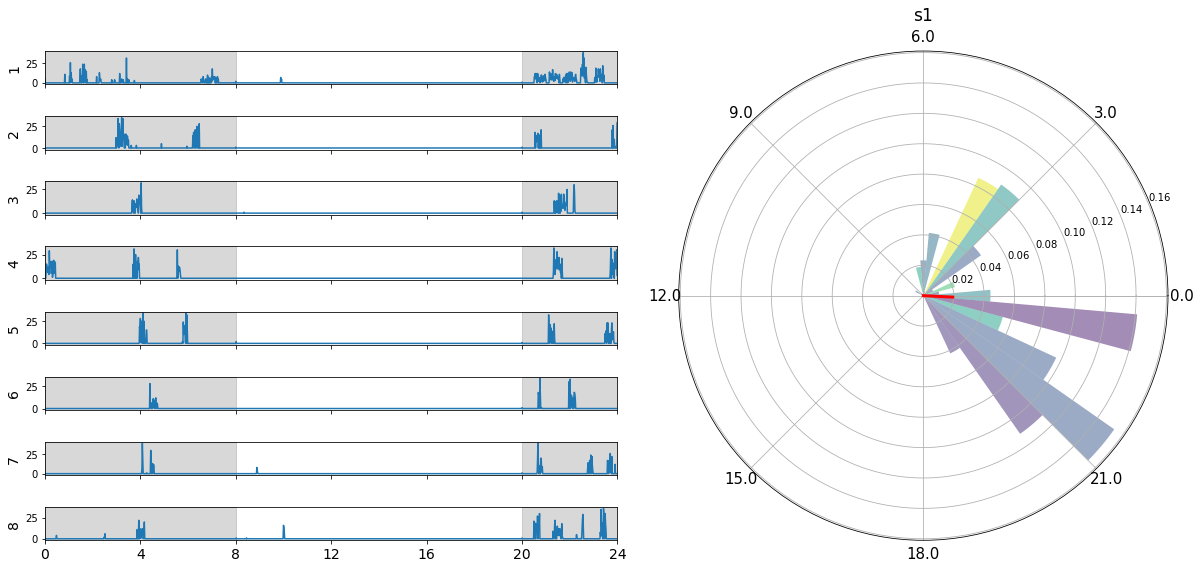

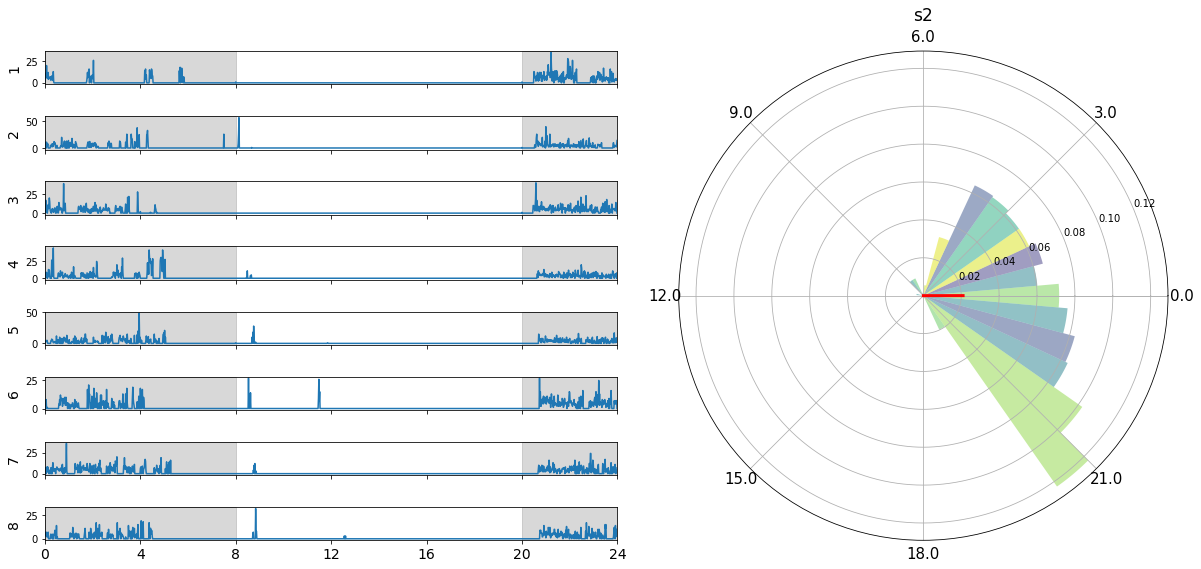

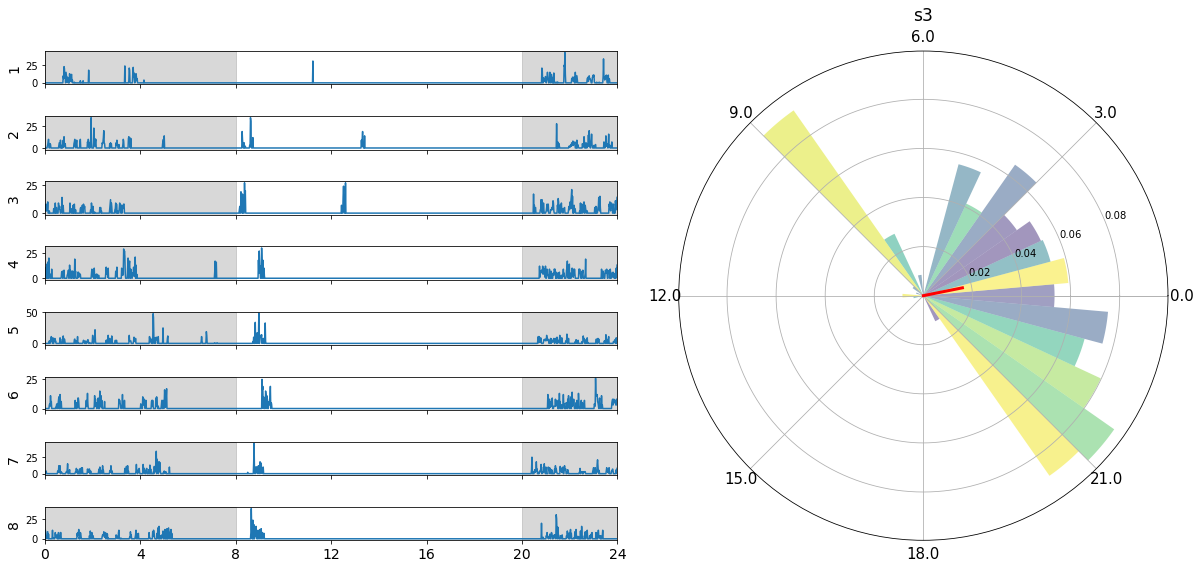

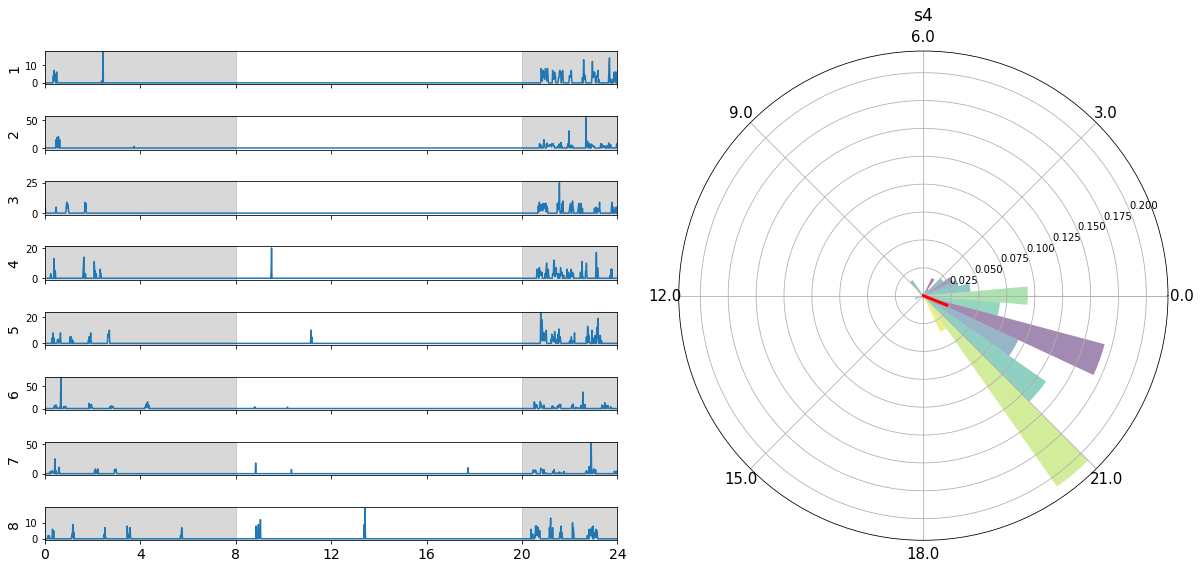

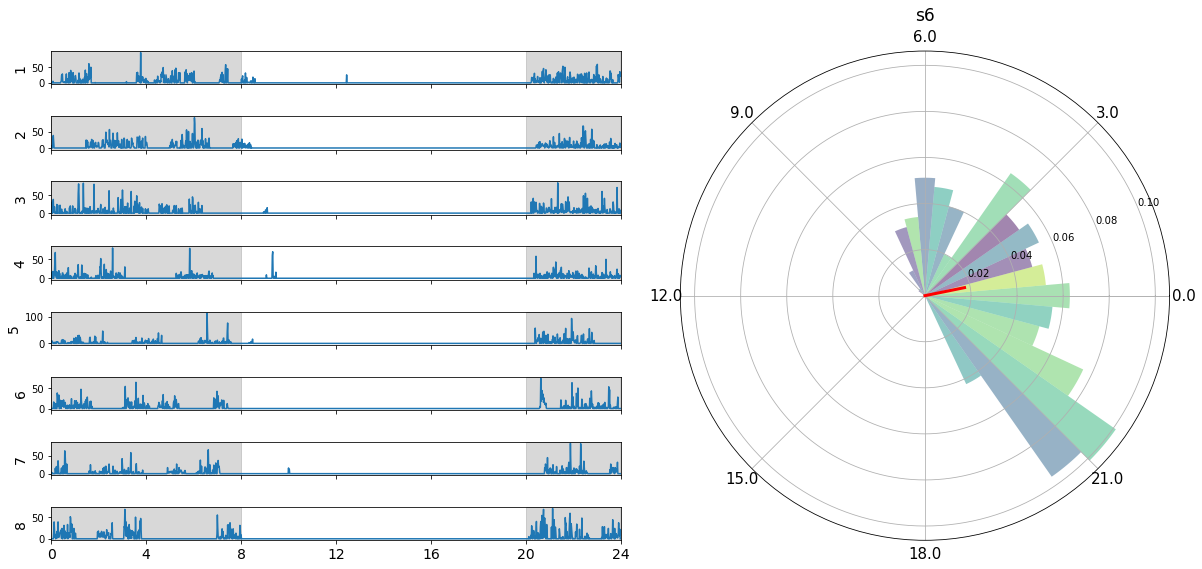

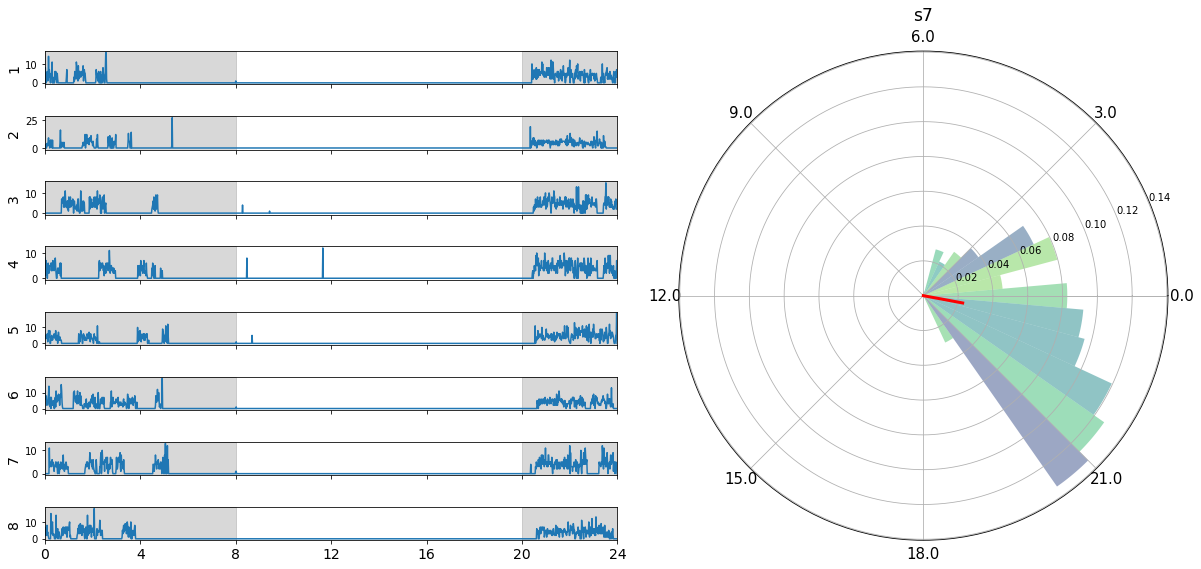

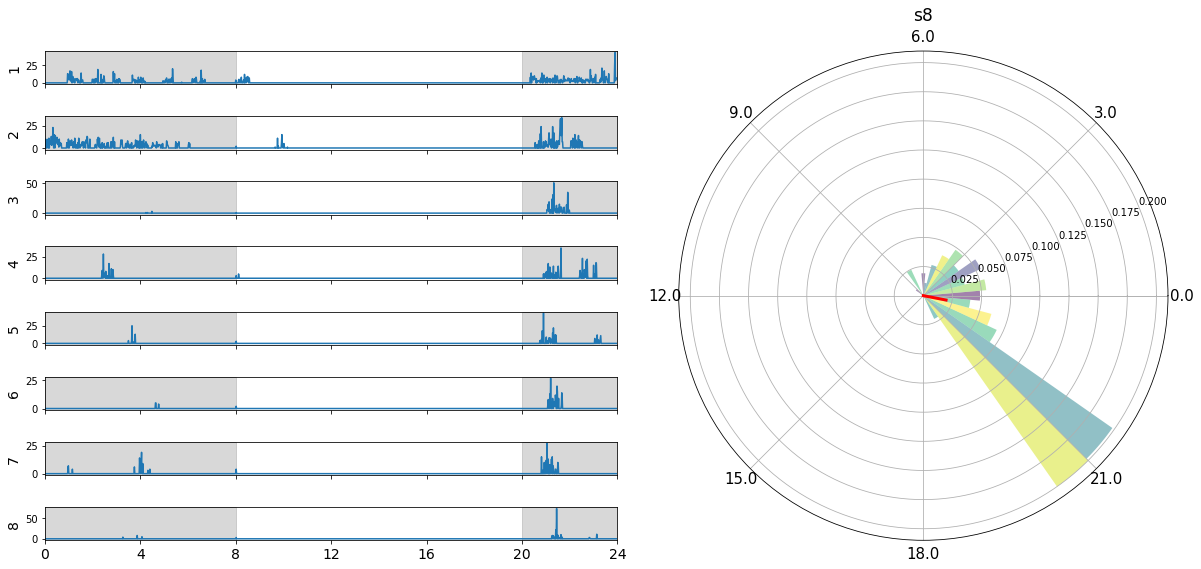

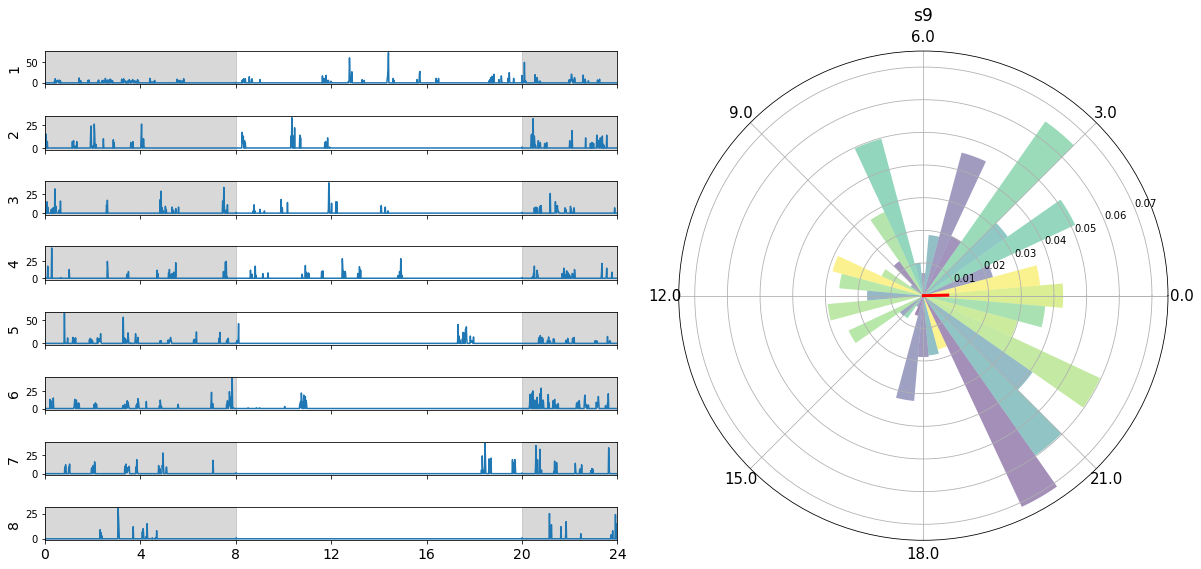

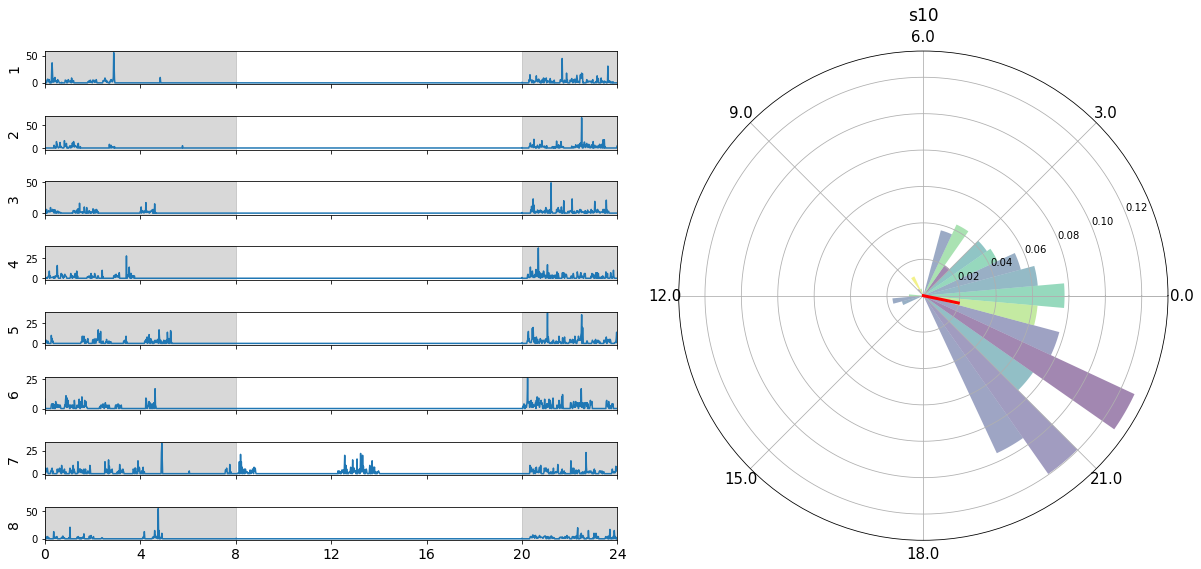

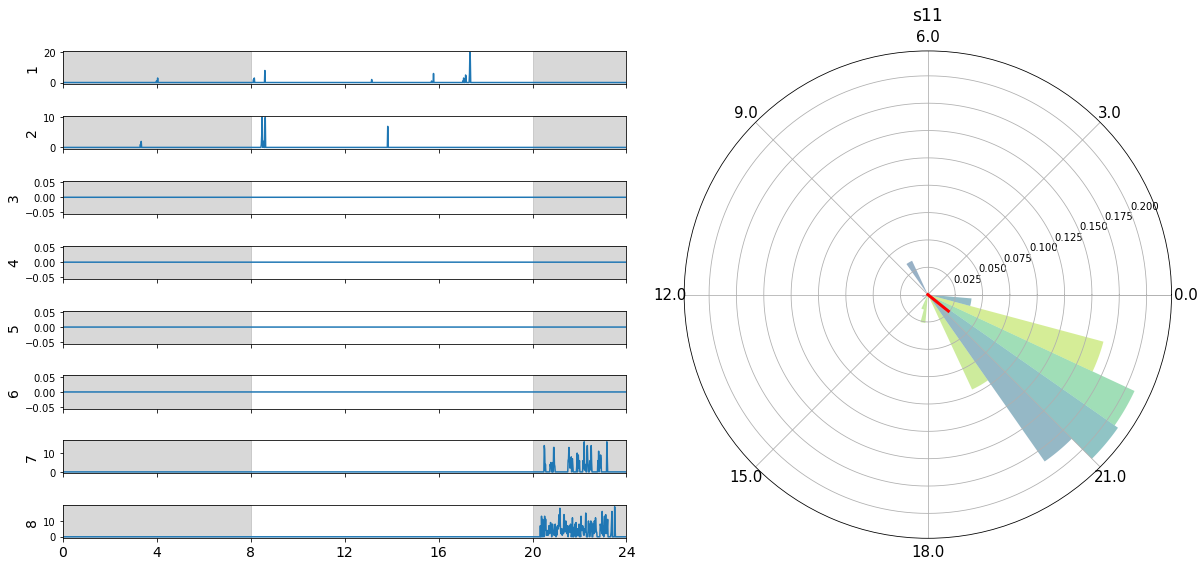

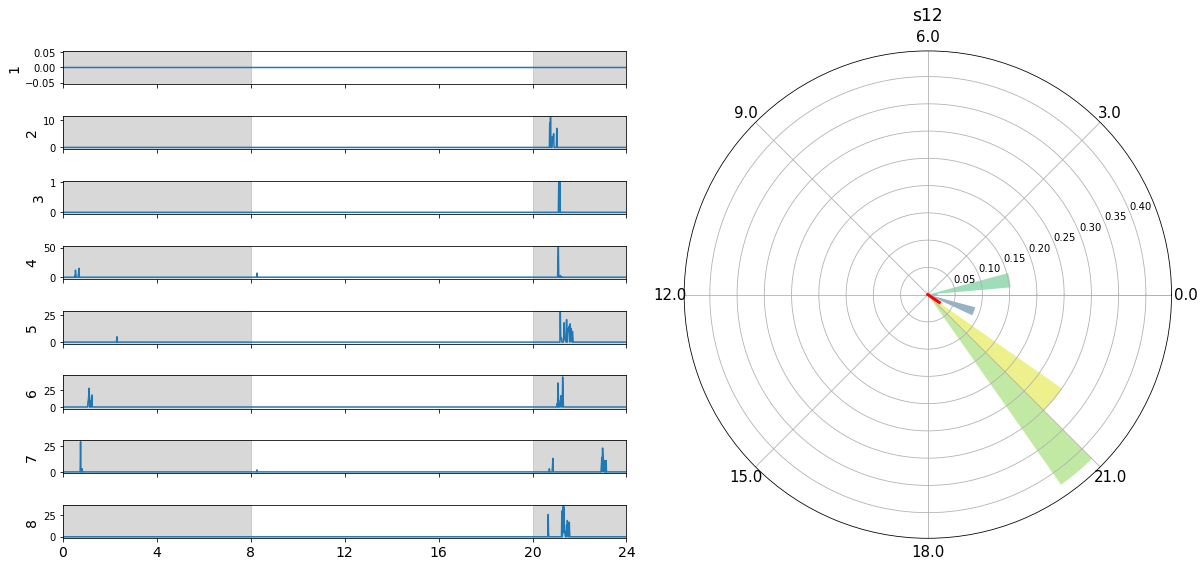

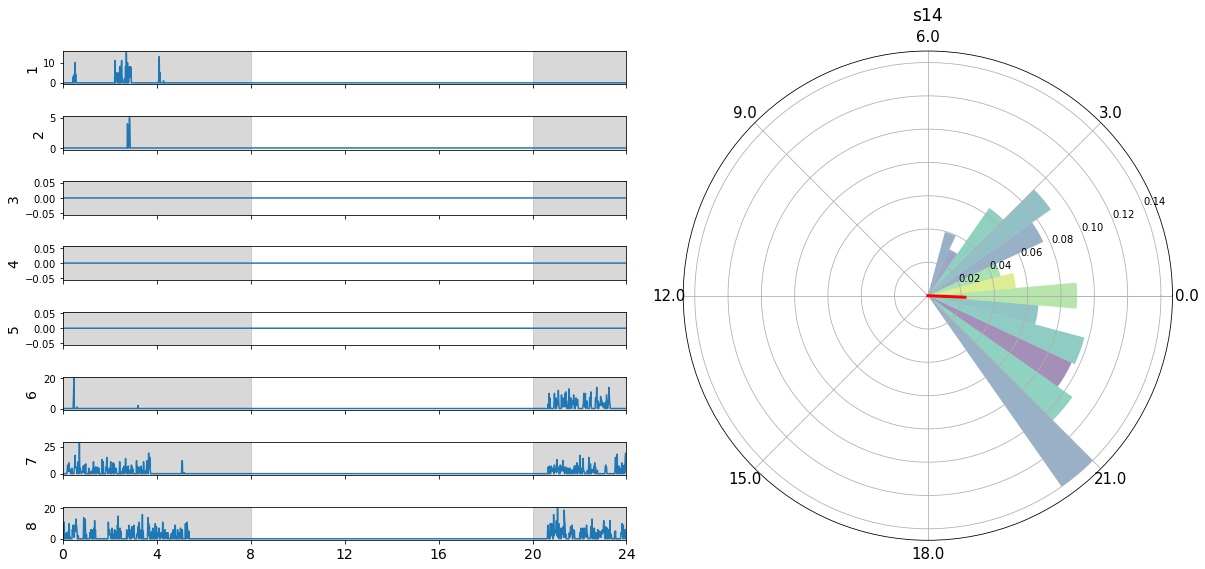

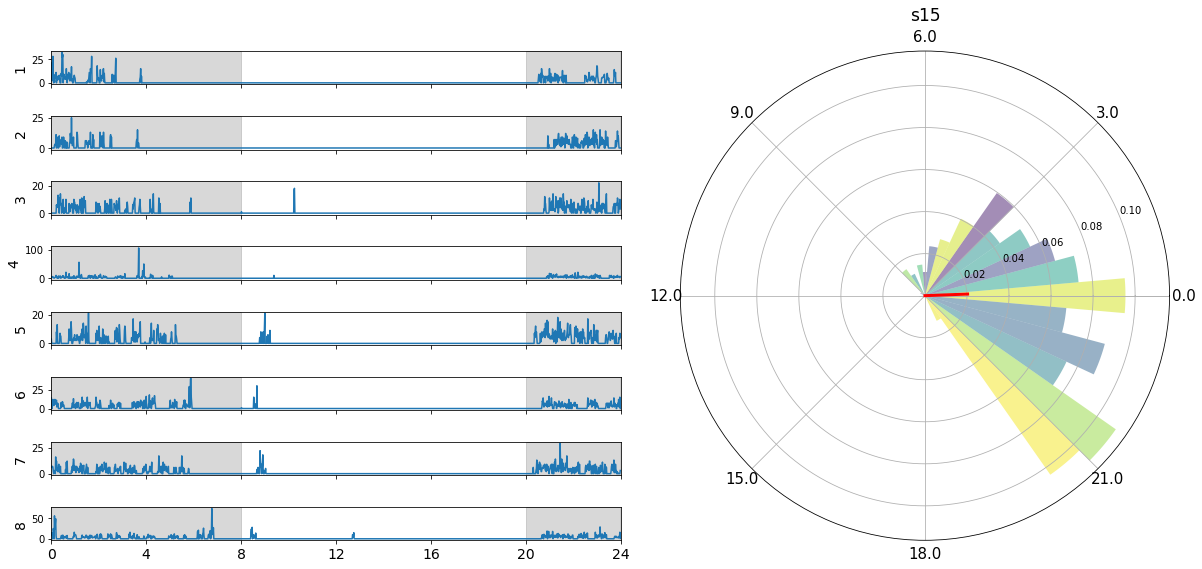

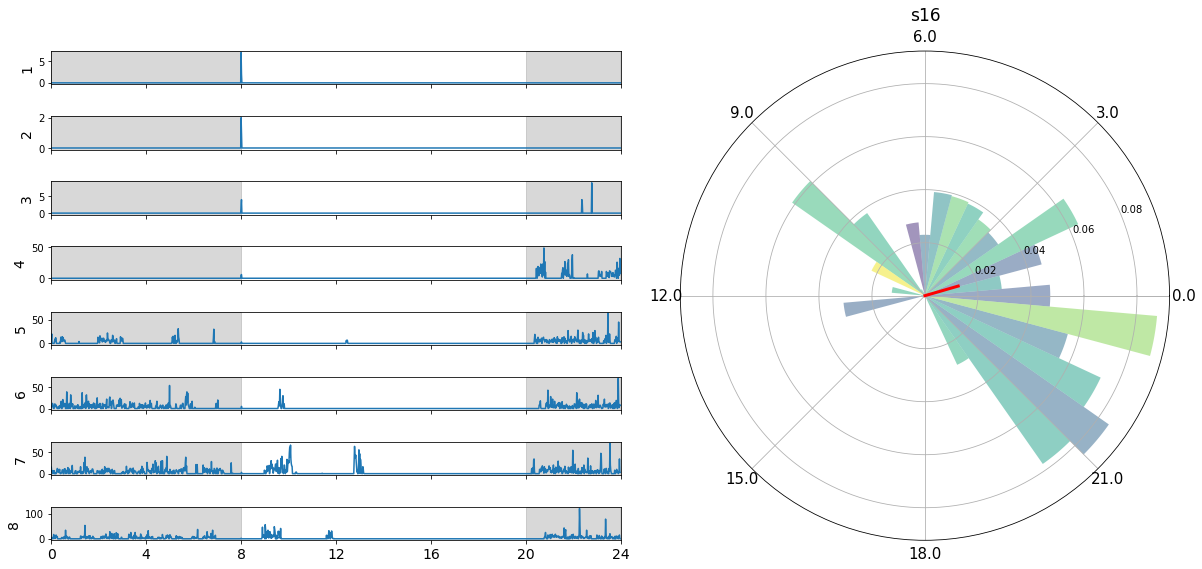

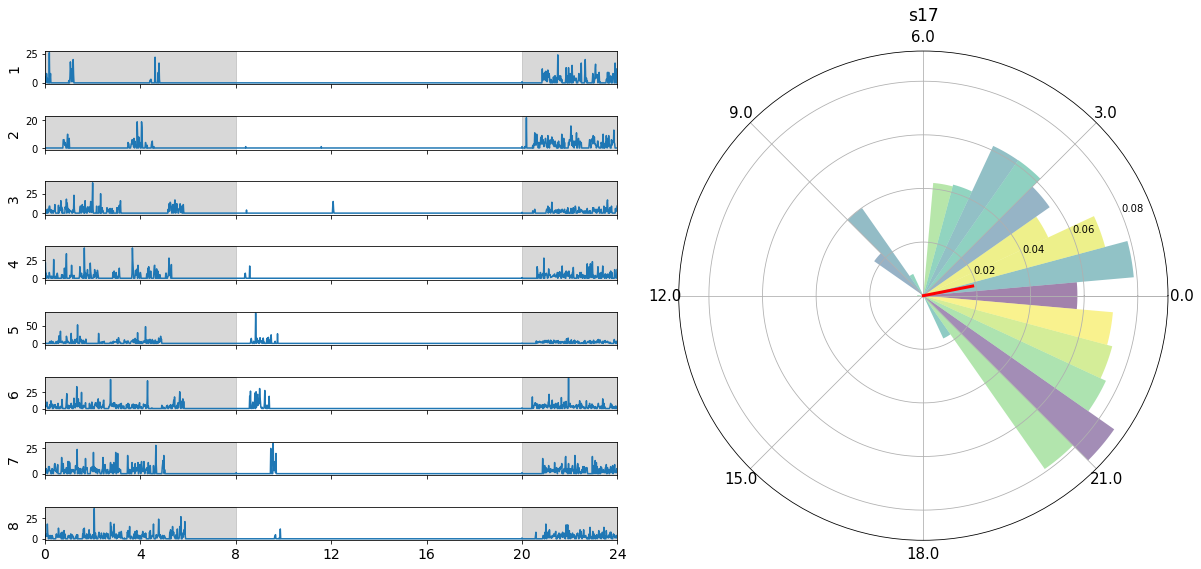

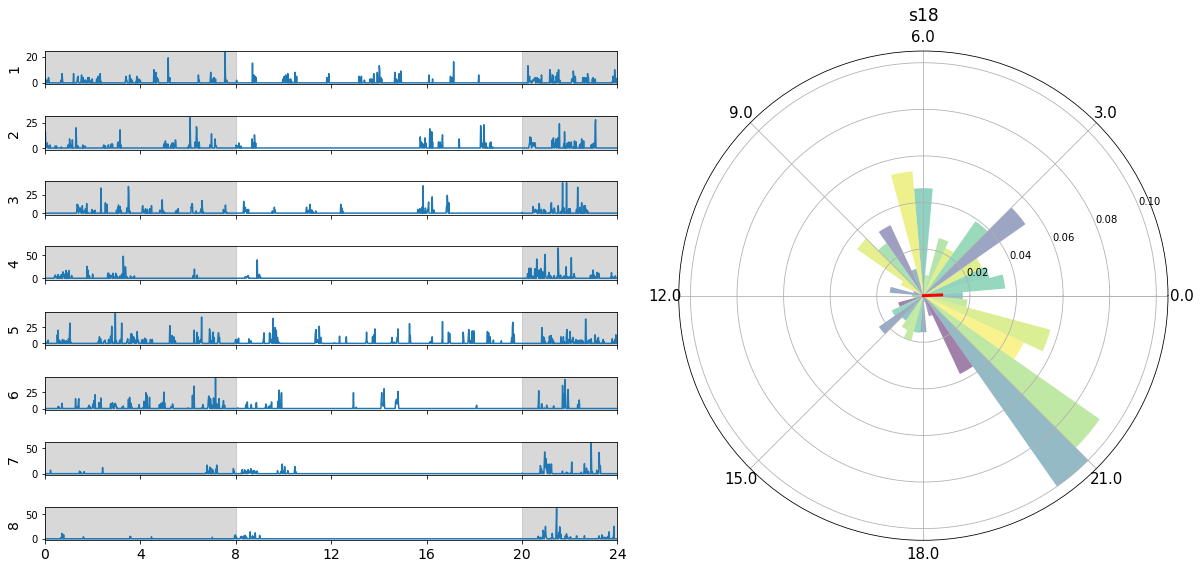

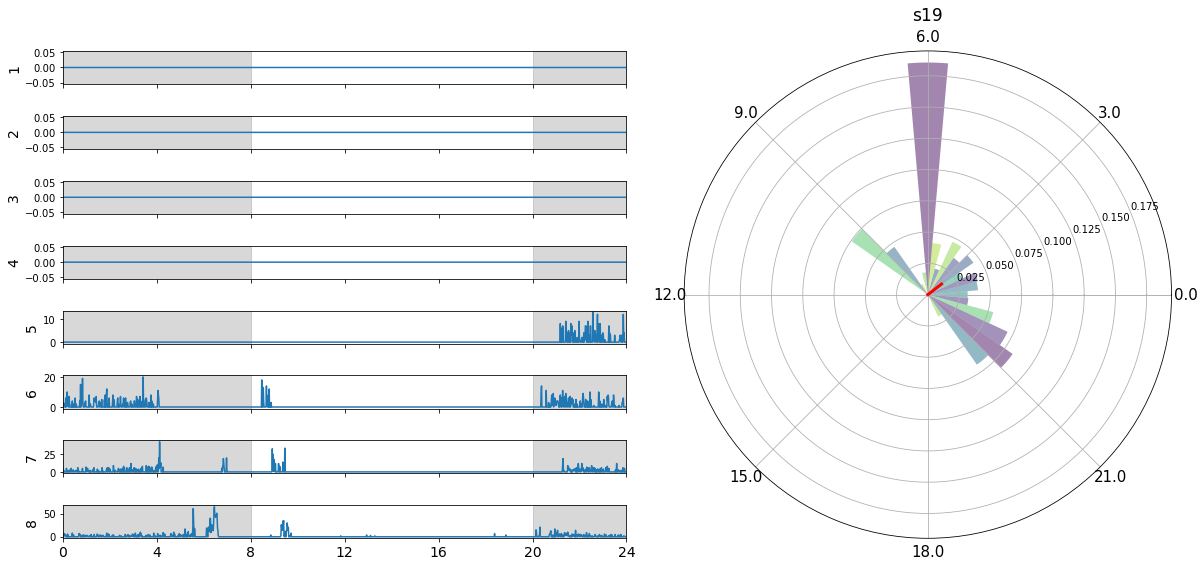

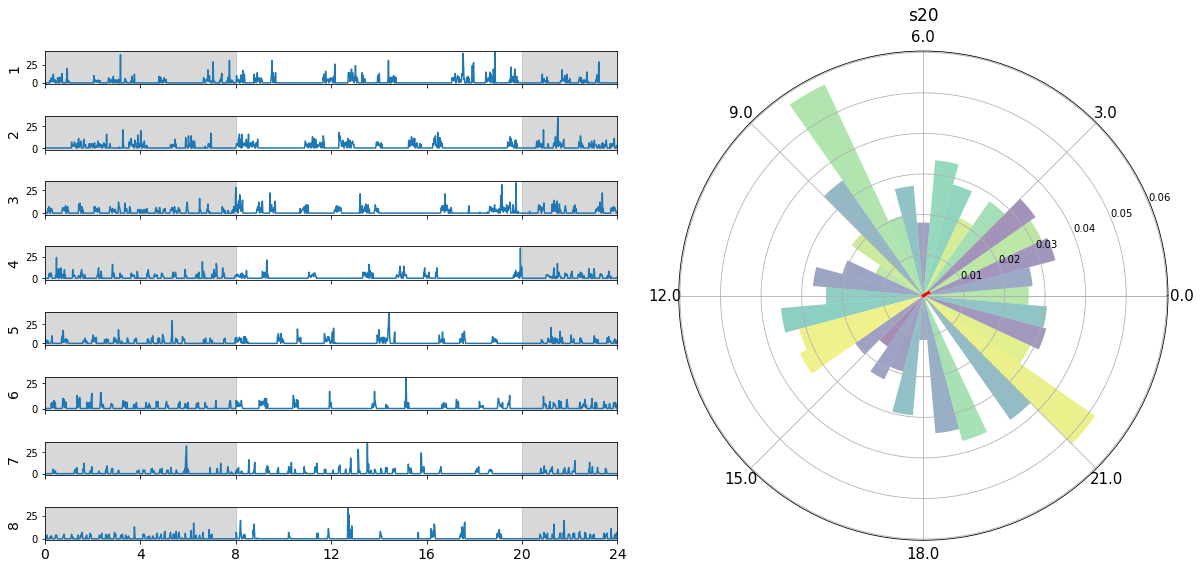

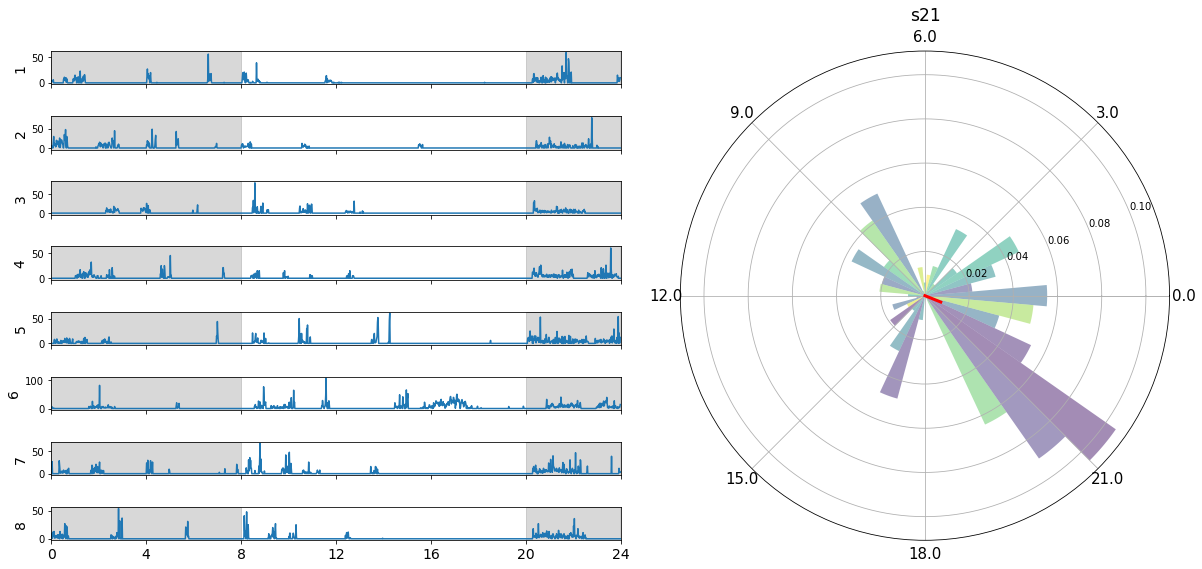

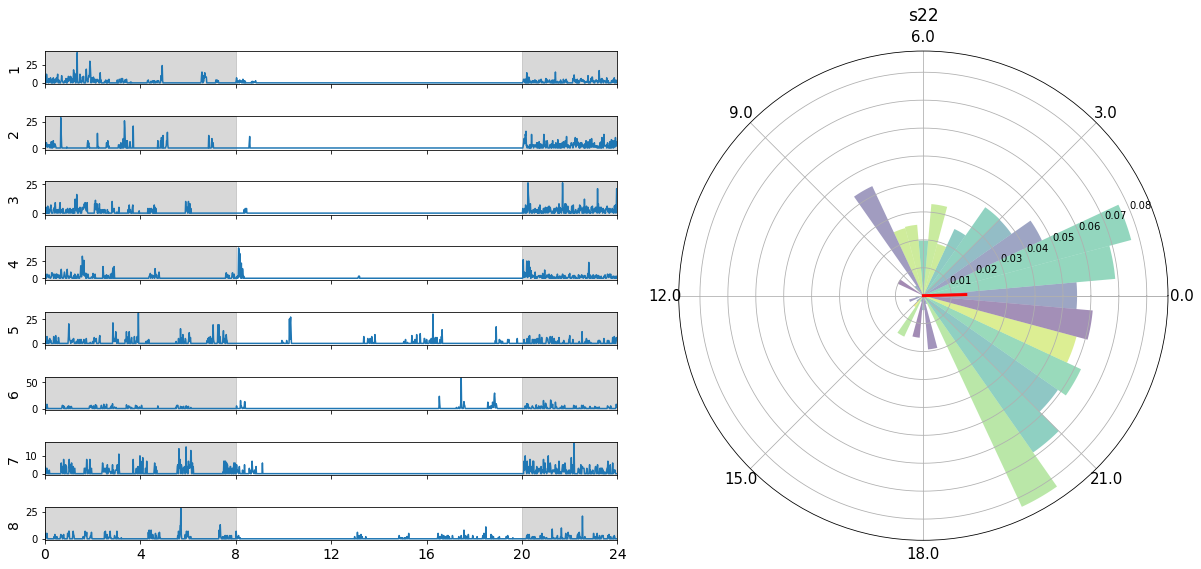

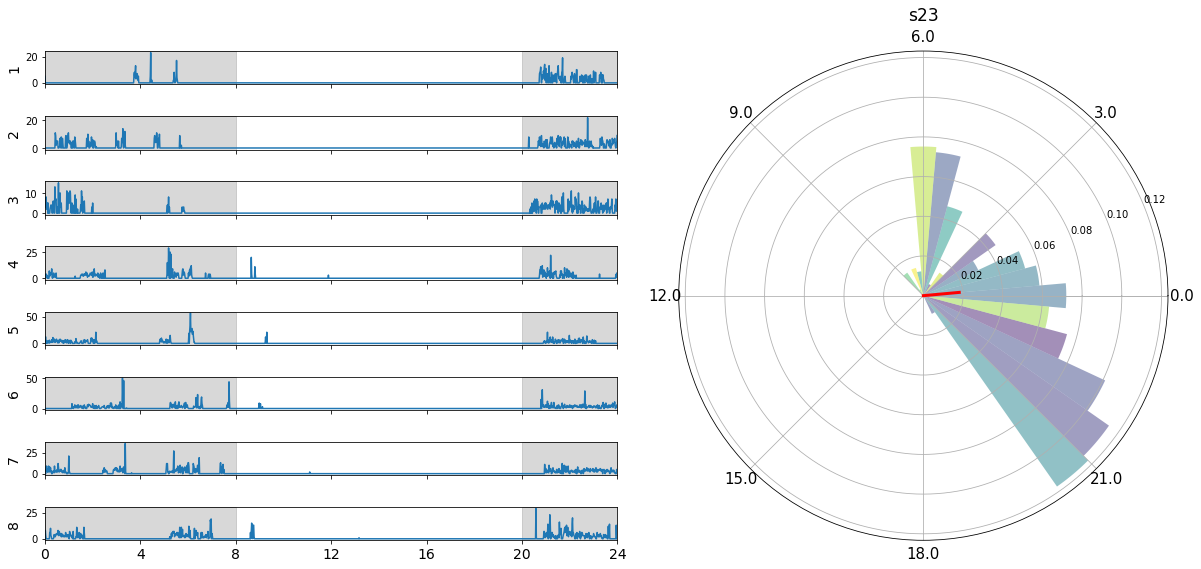

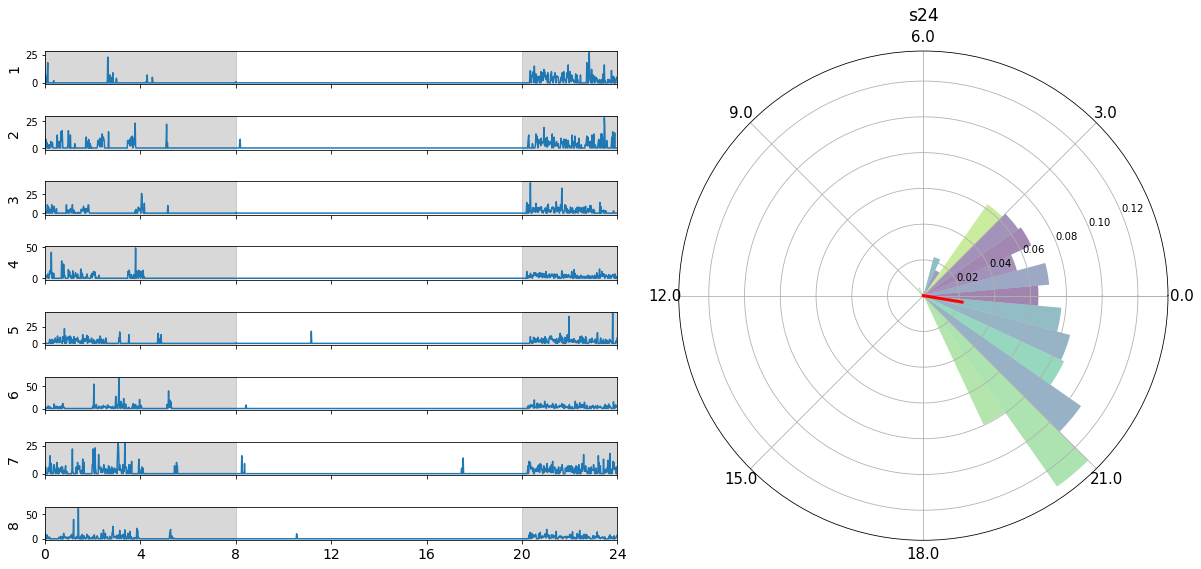

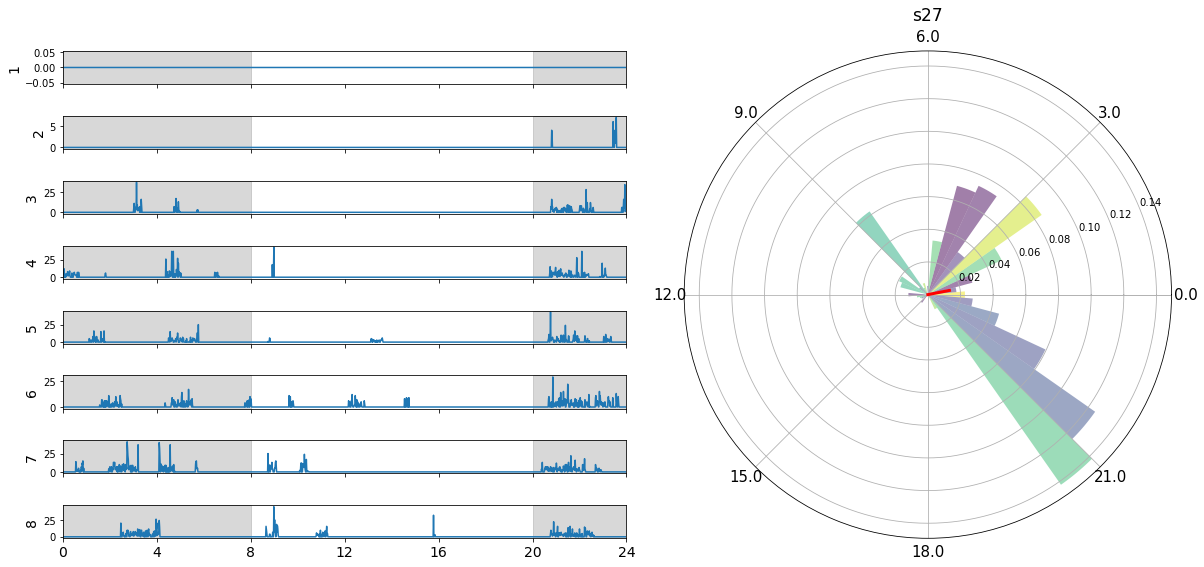

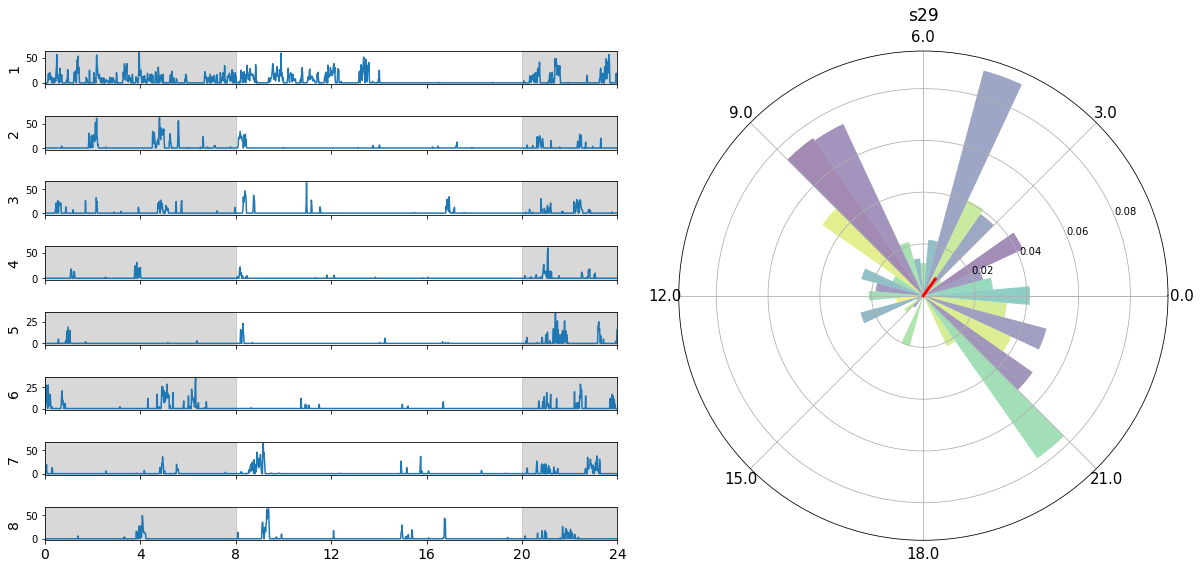

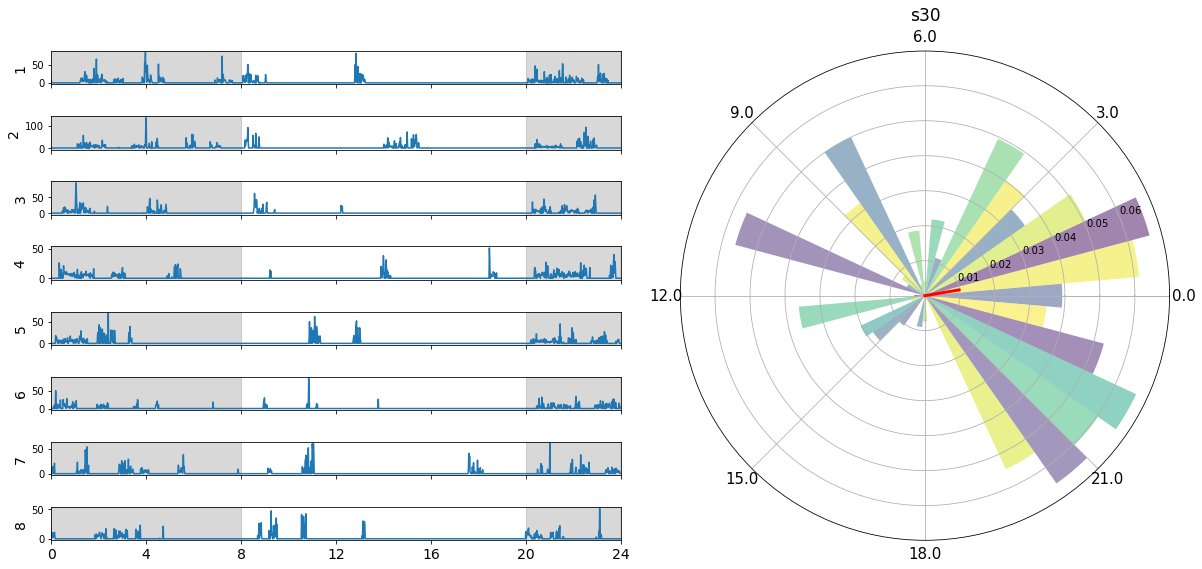

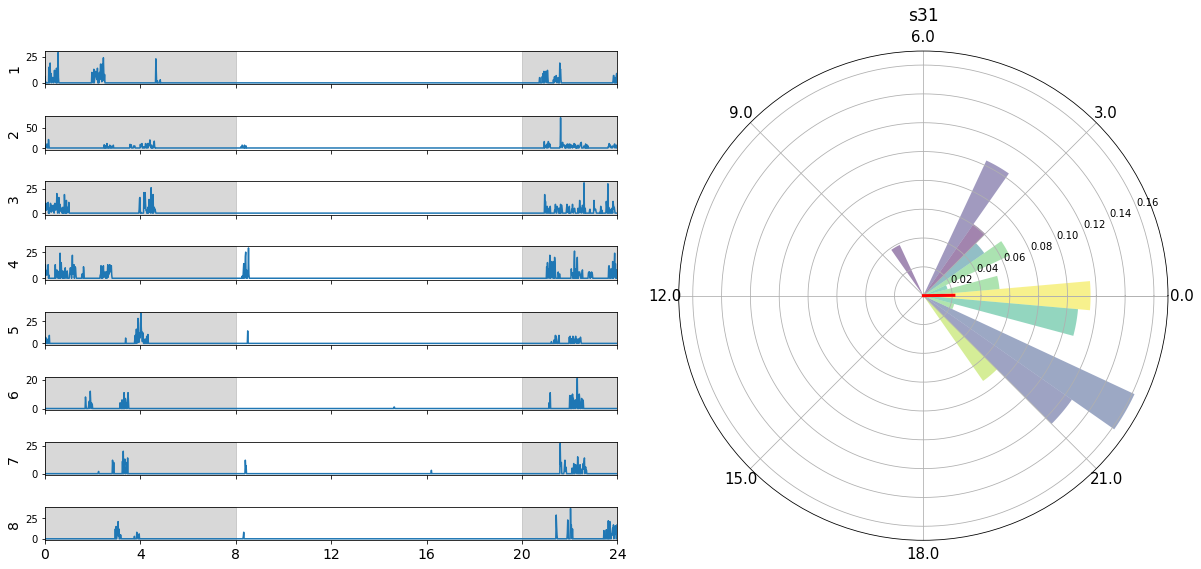

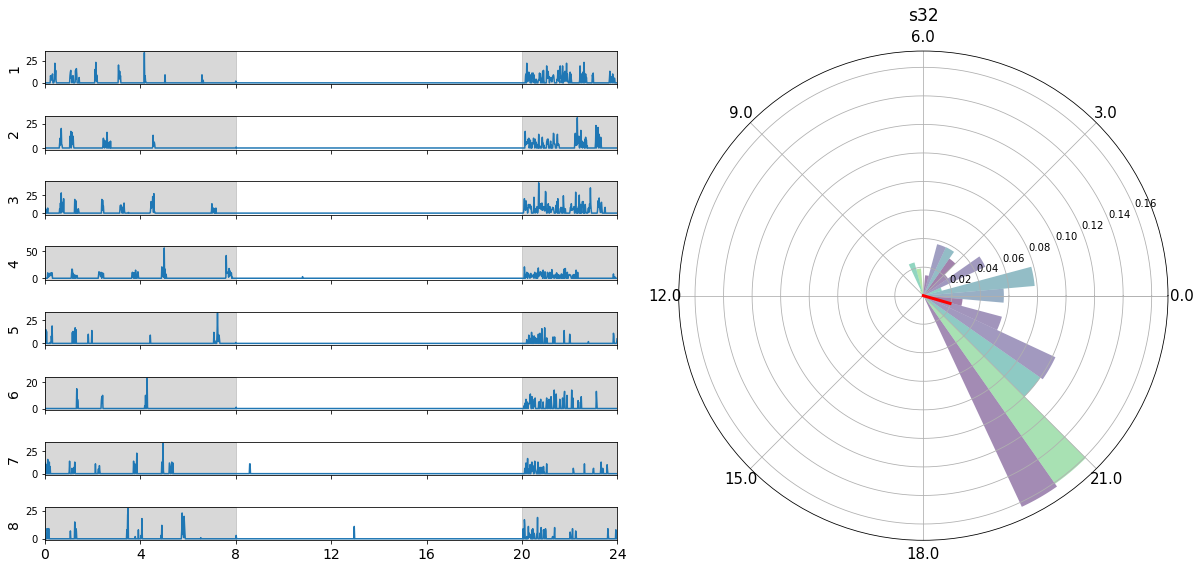

In [18]:
#Data file name containing the activity data to be analyzed
file_name='Para_LD.csv'

#md_ld: mean direction of each spider in LD period
#r_ld: r value of each spider in LD period
md_ld=[]
r_ld=[]
for spider in s:
    #Only use spiders whose DD period calculated by periodogram is statistically significant at the level of 0.001
     if df_period.loc[spider, 'p value']<=0.001:
        period=df_period.loc[spider, 'Period']
        obj=Circular(nbins=36)
        #For LD, the period is assumed to be 24h which is the length of a normal day
        obj.run(file_name, spider, 24.)
        obj.run_plot(spider)
        #Save the mean direction and r value in the lists
        md_ld.append(obj.theta_avg)
        r_ld.append(obj.r_total)

### Save the circular statistics for each spider in .csv file

In [19]:
#Output file name
output_filename_LD='Mean_Para_LD.csv'

#Save the mean direction and r value (mean length) in a dataframe
para_ld=pd.DataFrame({'Mean Direction': md_ld, 'Mean Length': r_ld}, index=df_period[df_period['p value']<=0.001].index)
#Save as a .csv file
para_ld.to_csv(output_filename_LD)
para_ld.head()

Mean Direction  Mean Length
Spider                             
s1           -2.790347     0.697002
s2            0.064643     0.755034
s3           11.349971     0.584368
s4          -22.211836     0.815343
s6           11.485014     0.631736

## DD Period

Here we perform the whole procedure for LD period.

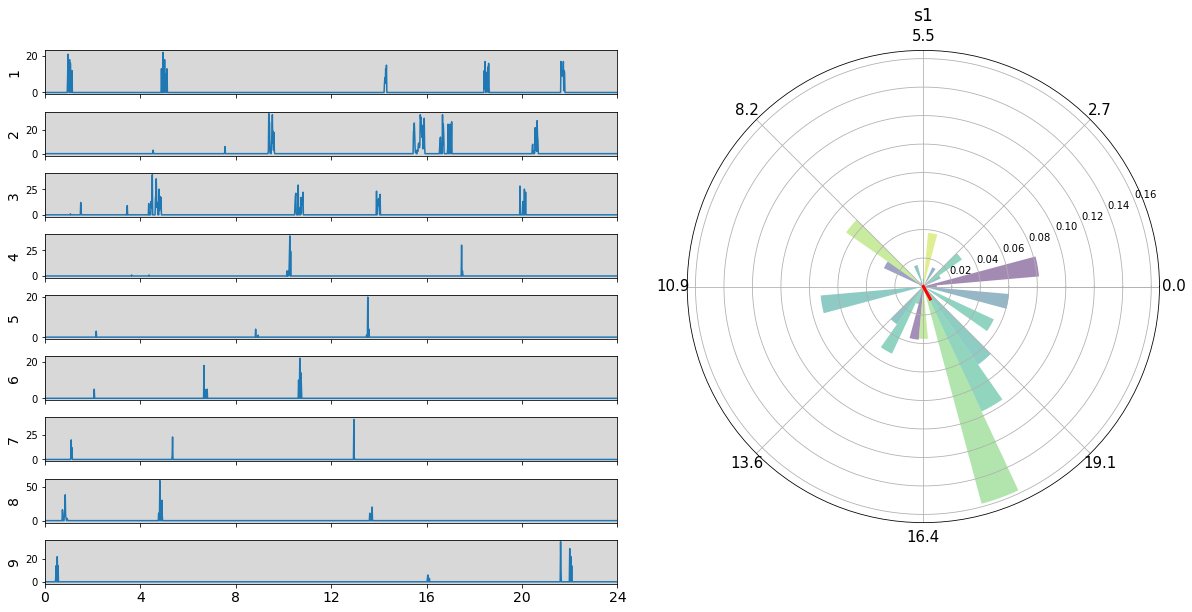

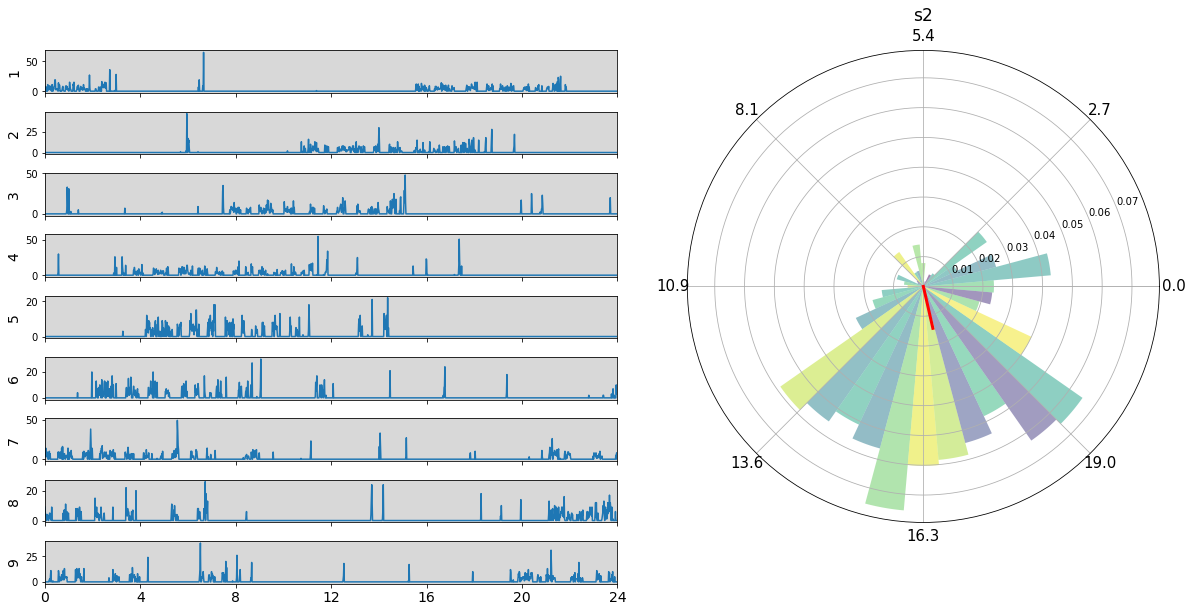

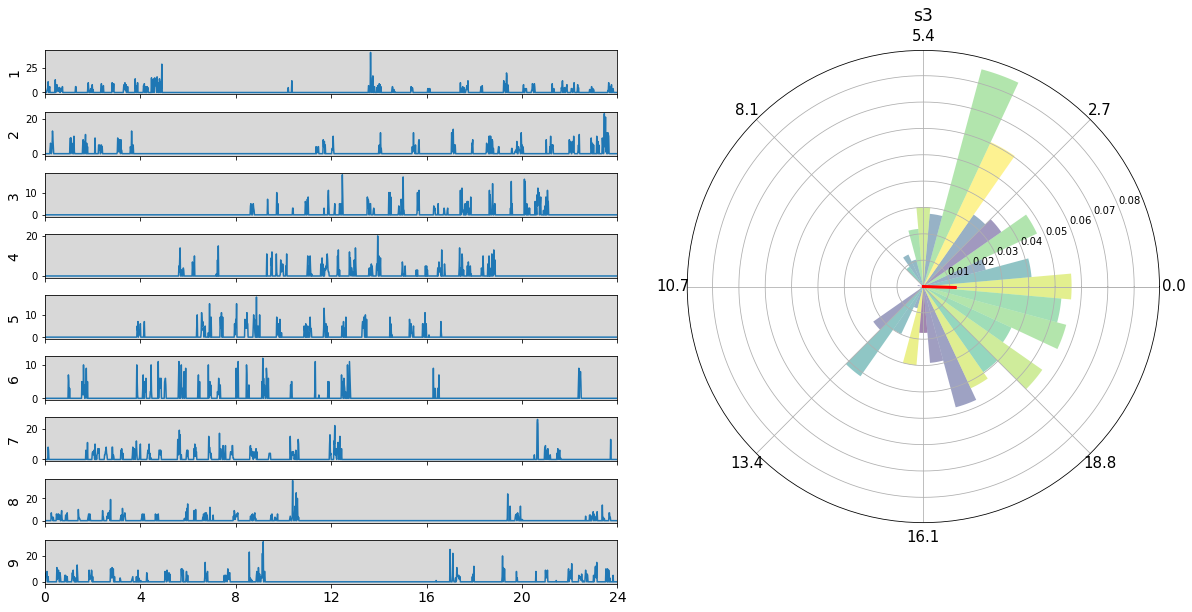

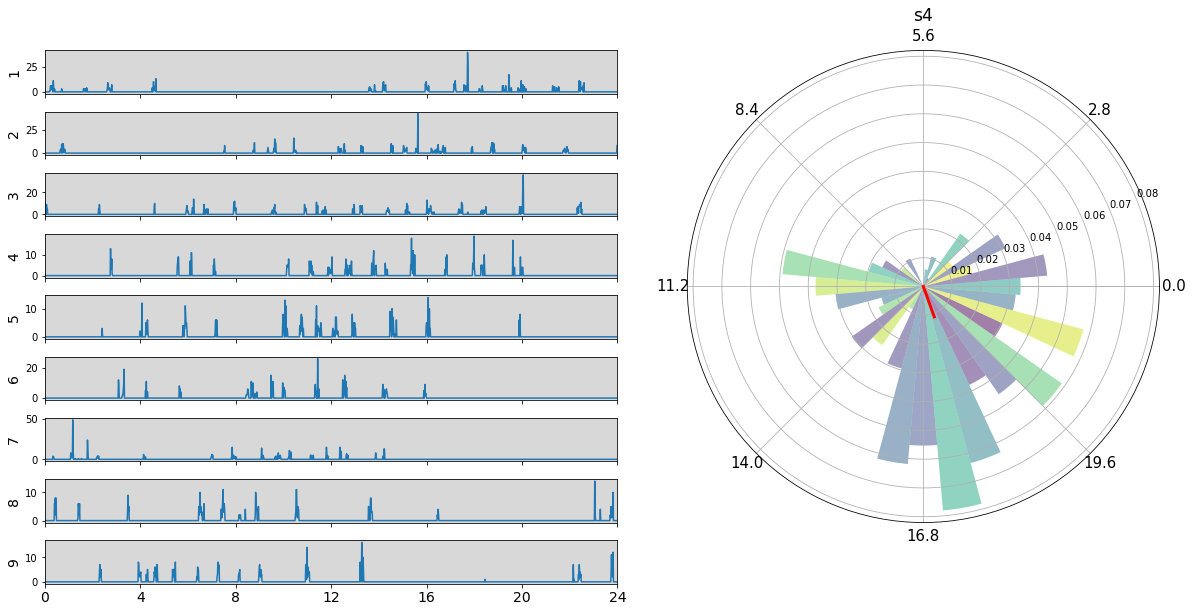

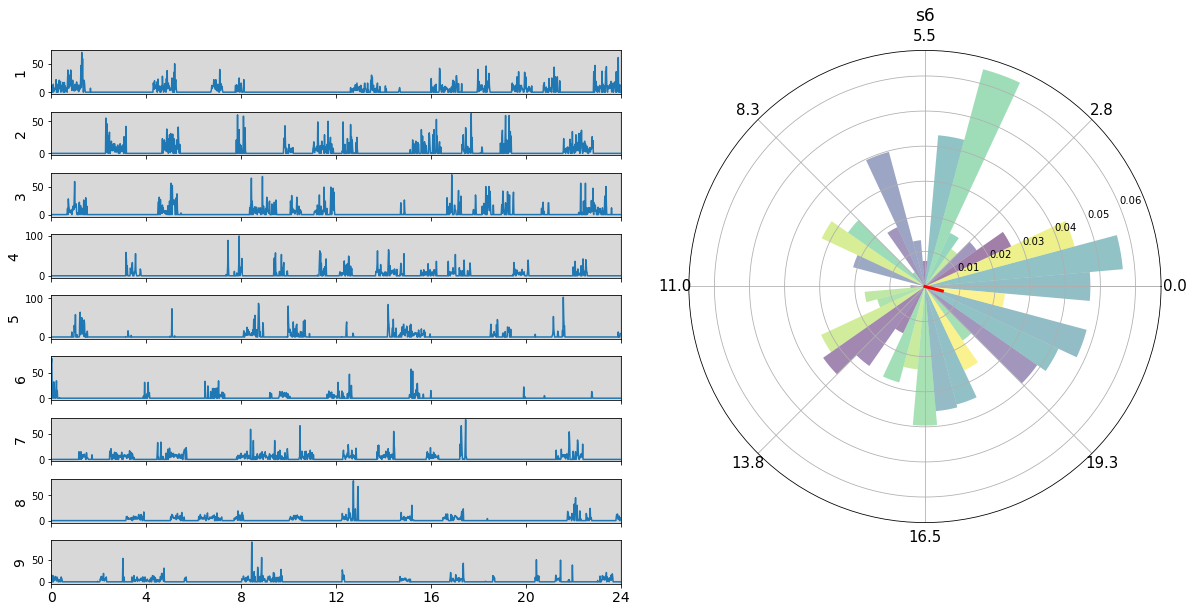

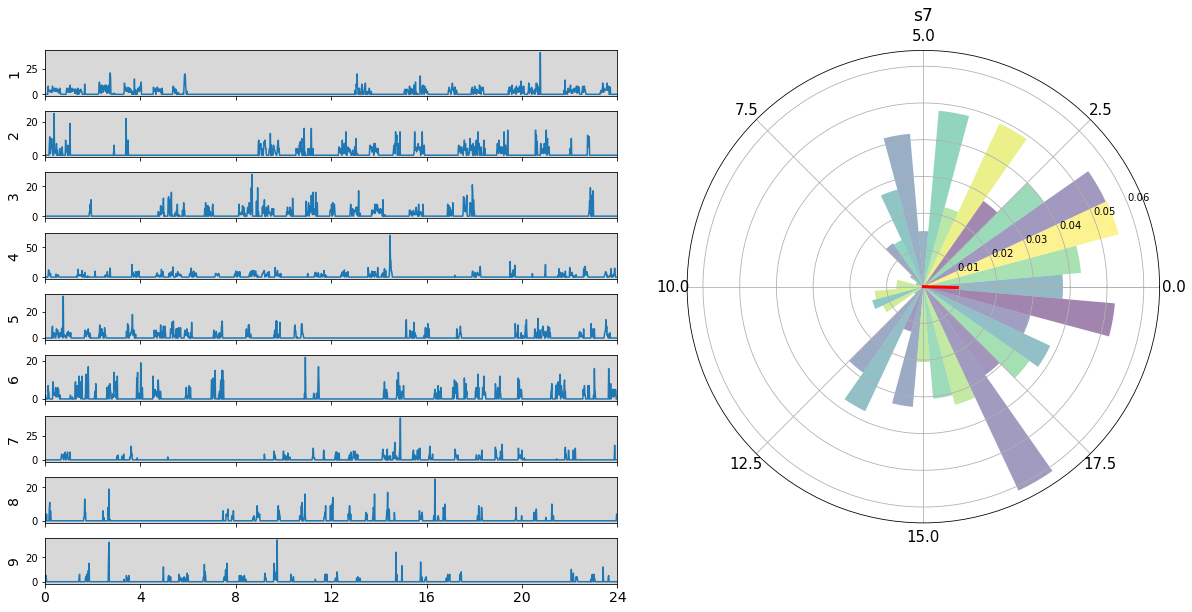

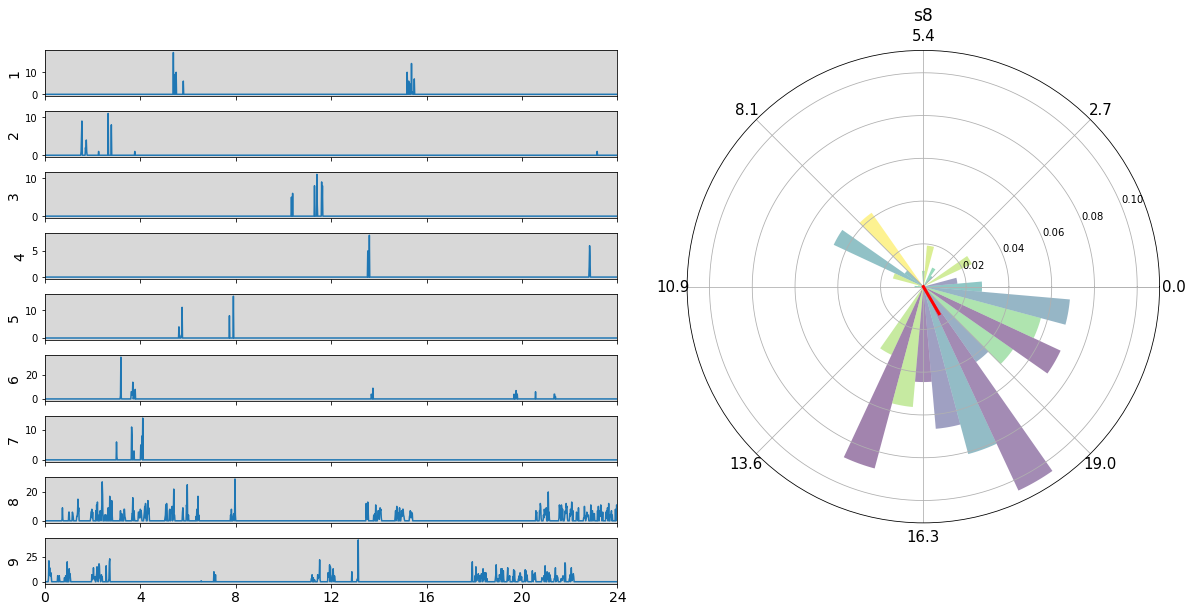

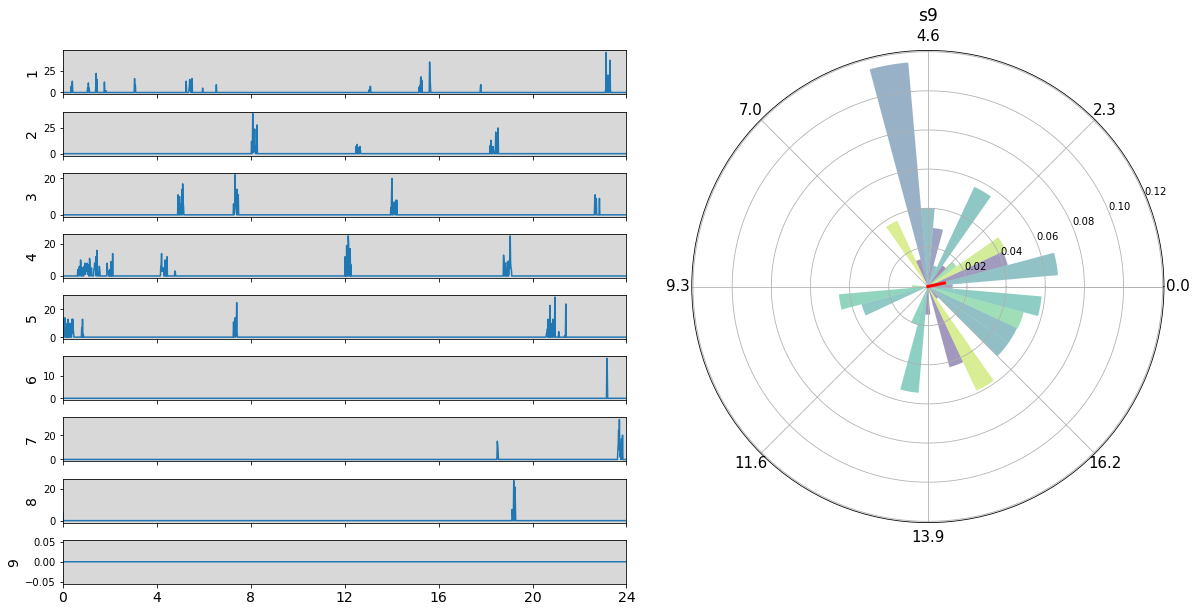

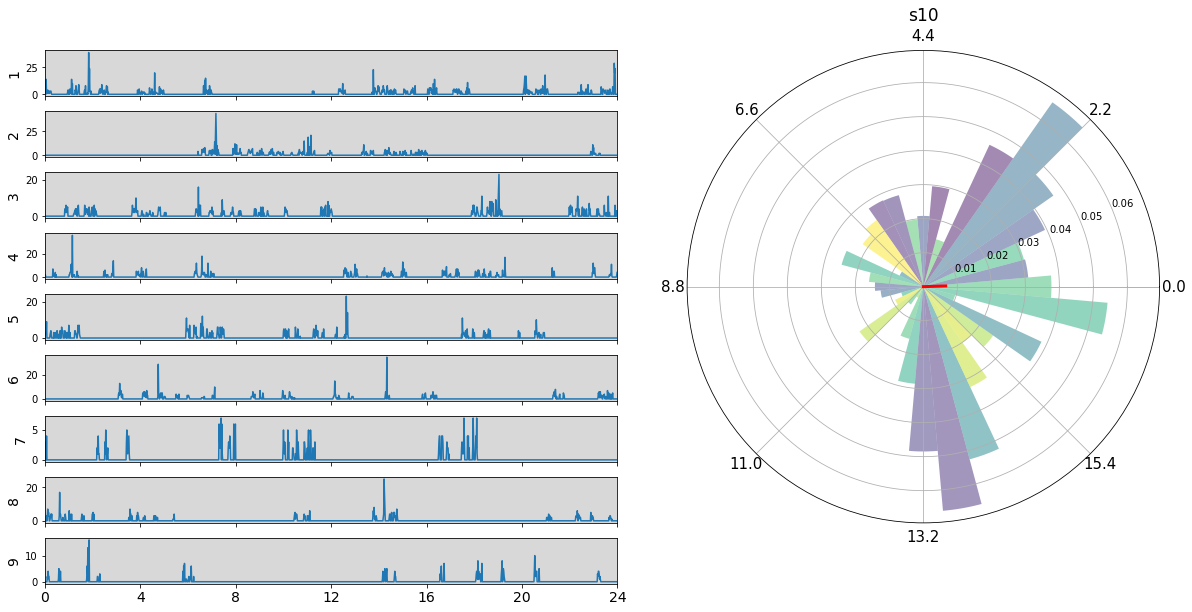

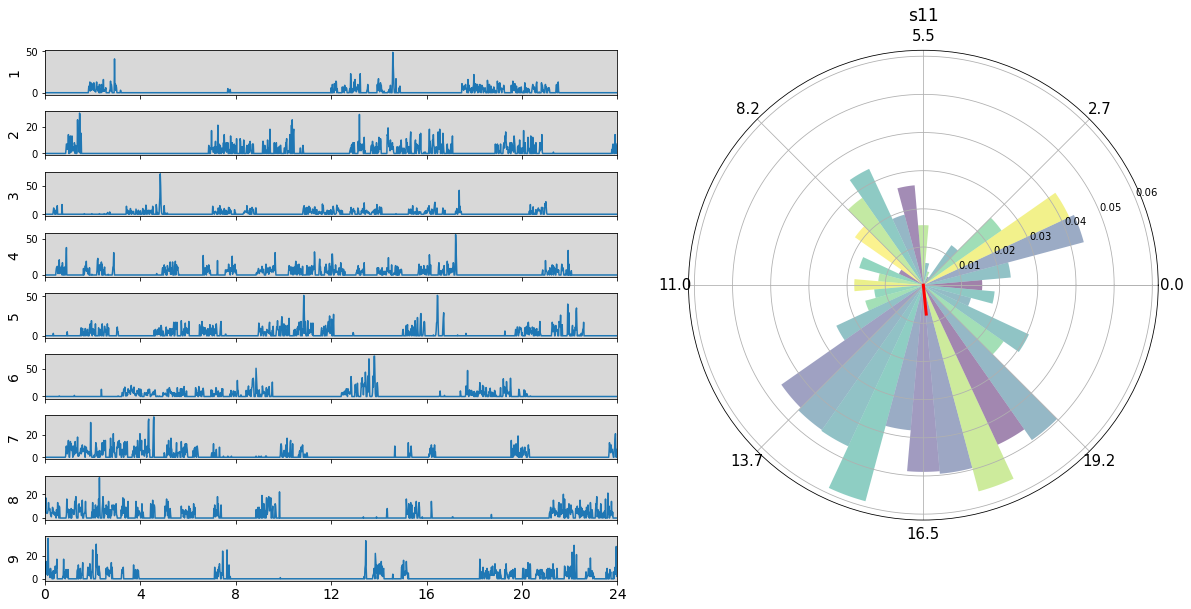

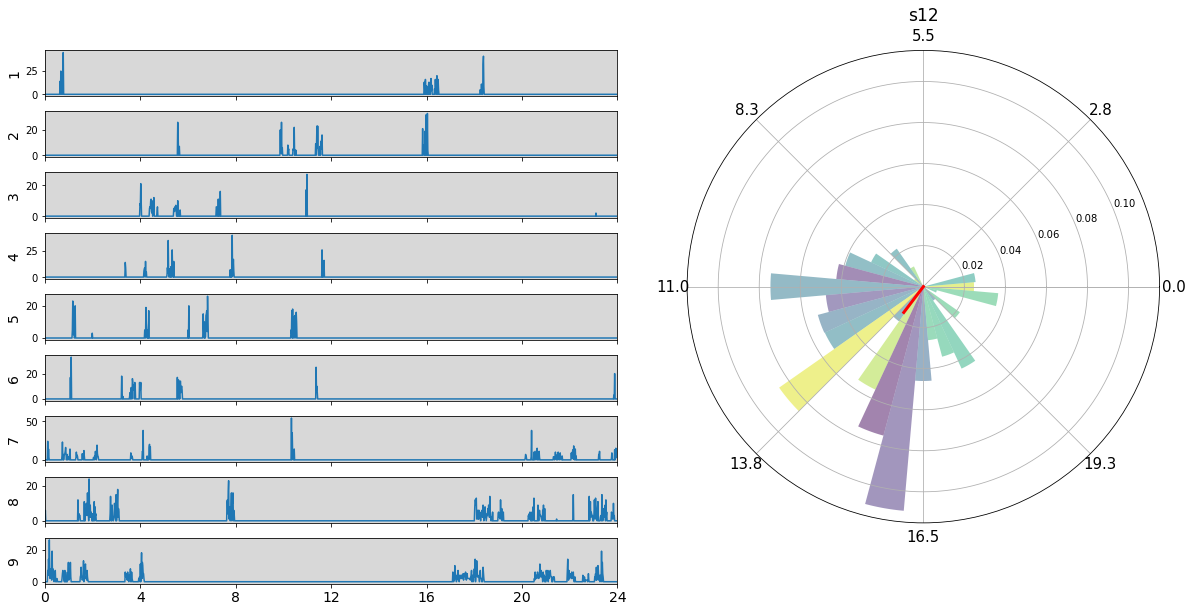

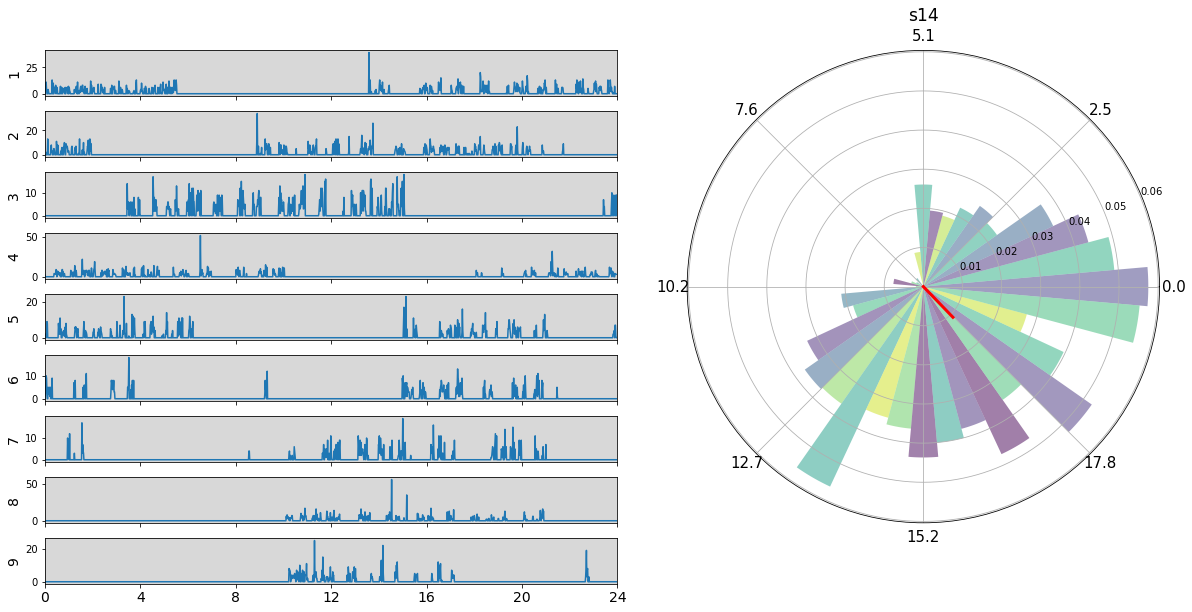

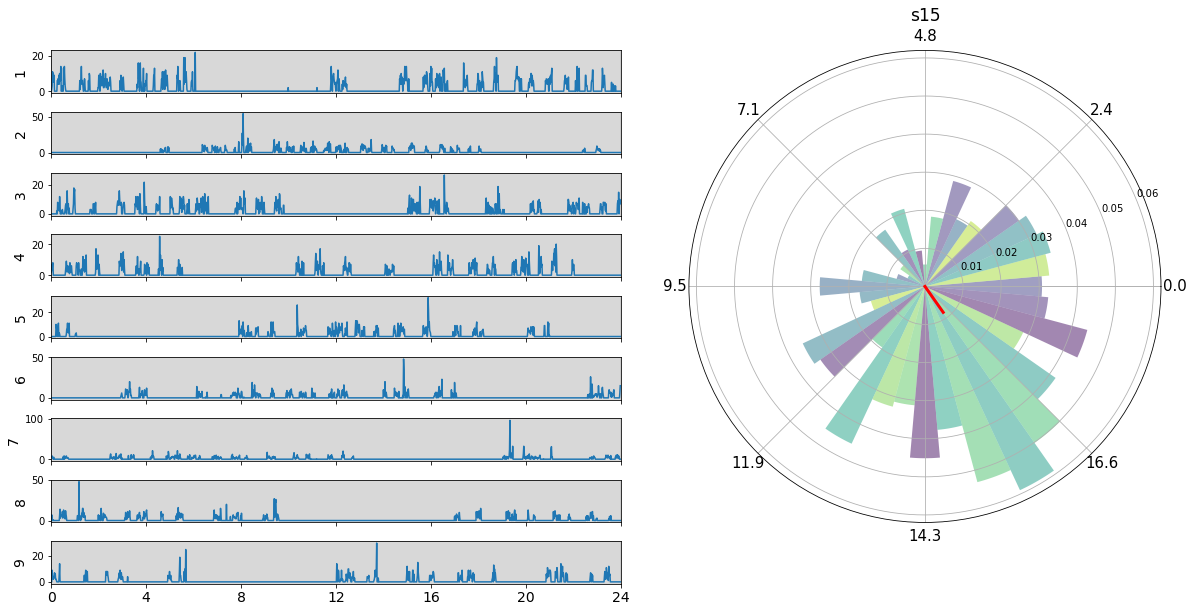

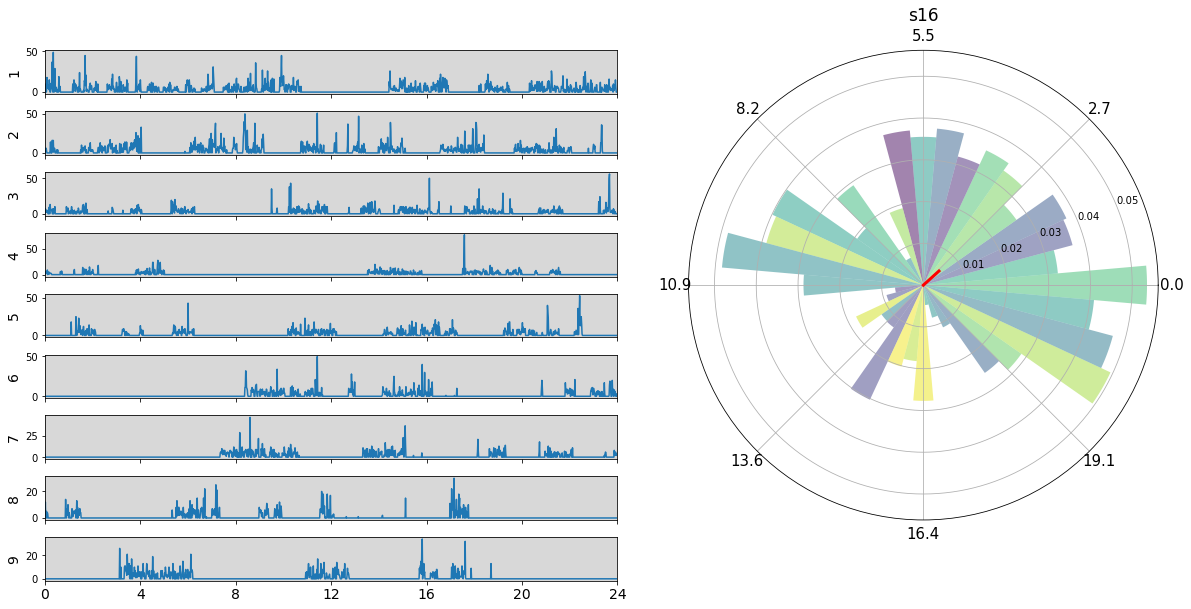

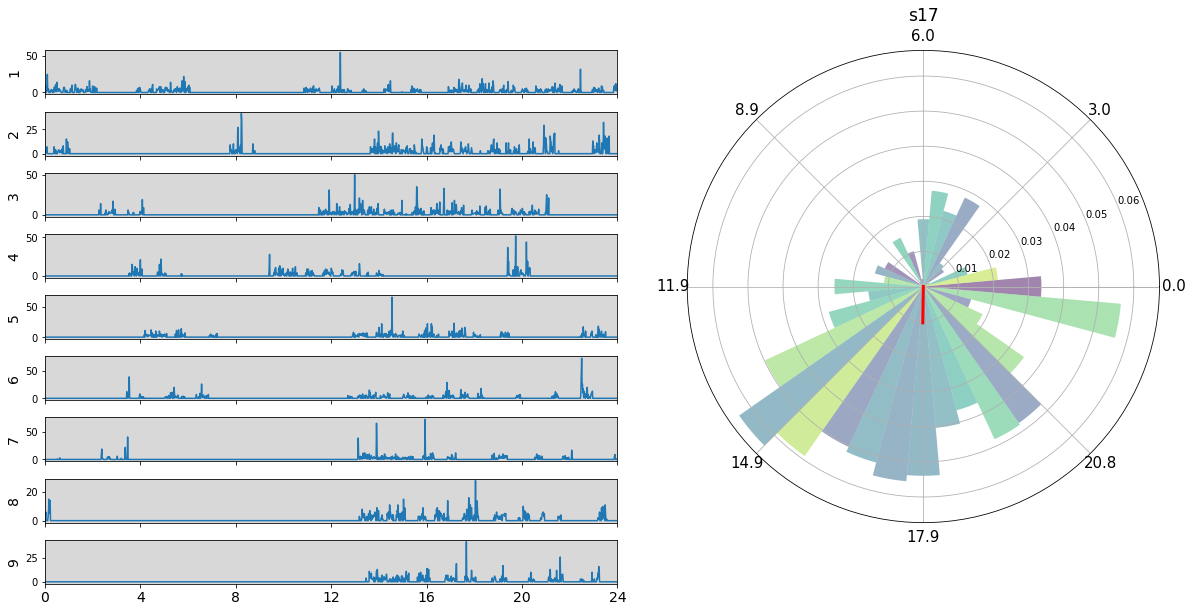

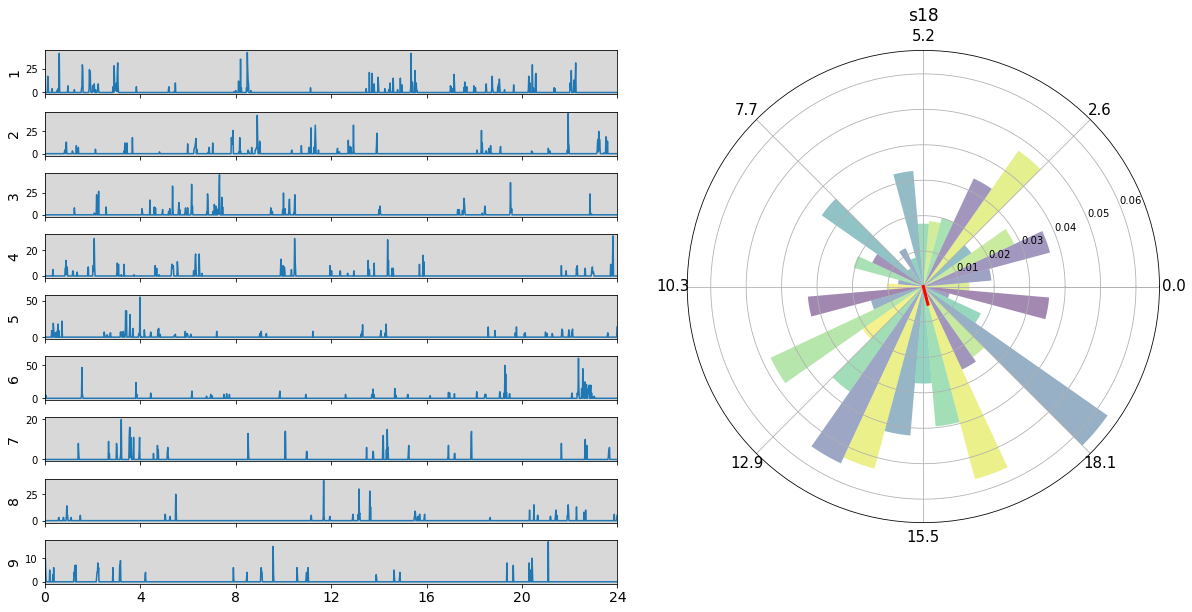

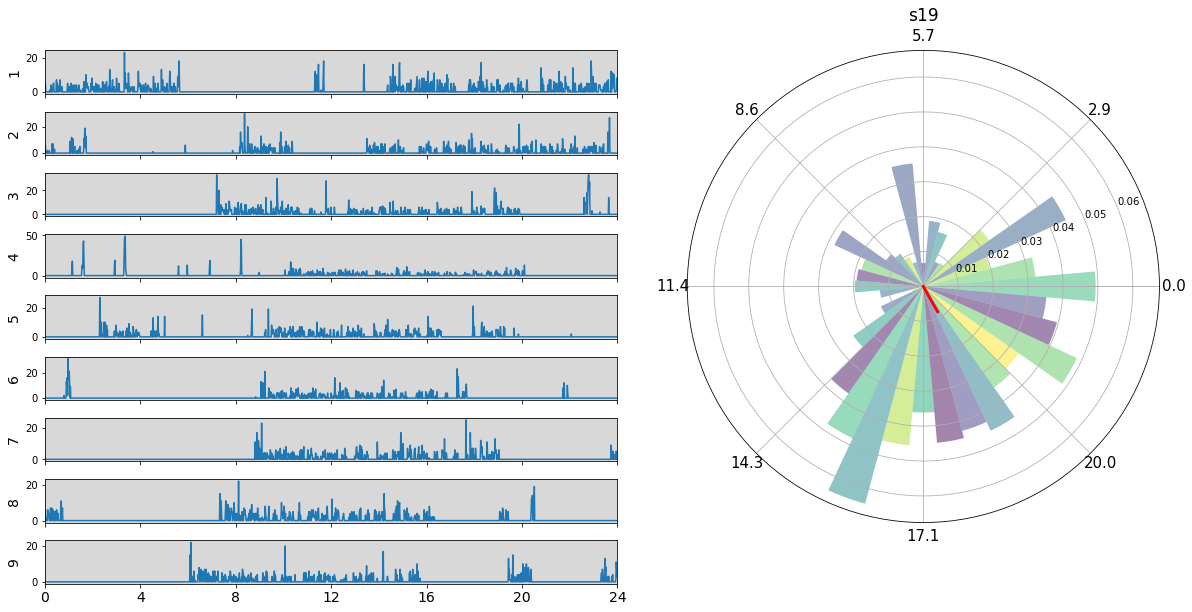

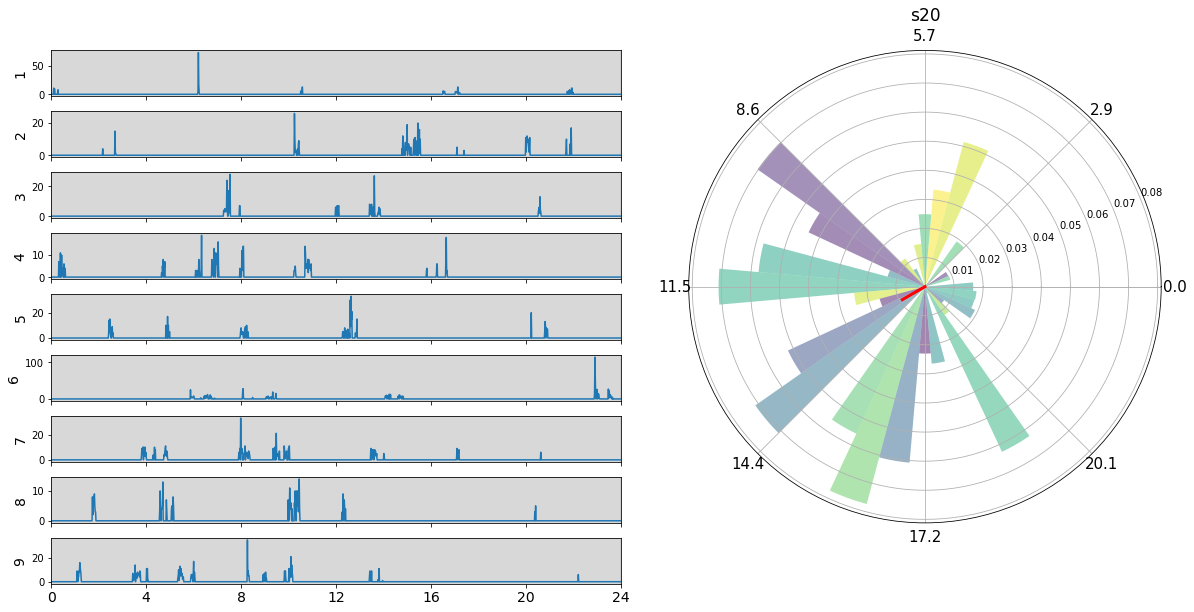

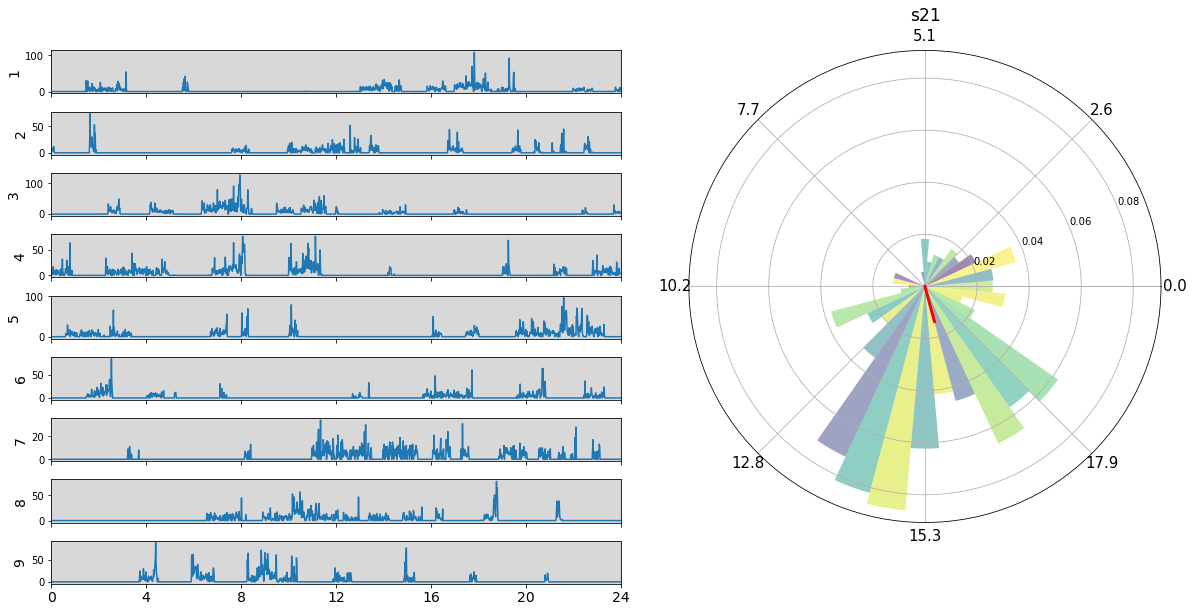

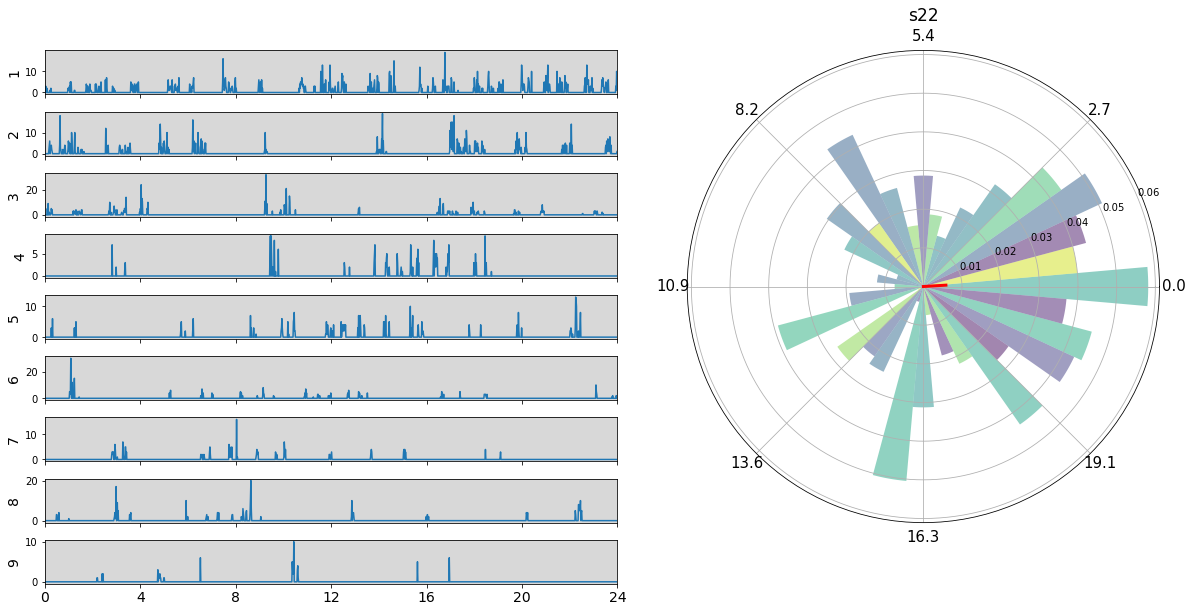

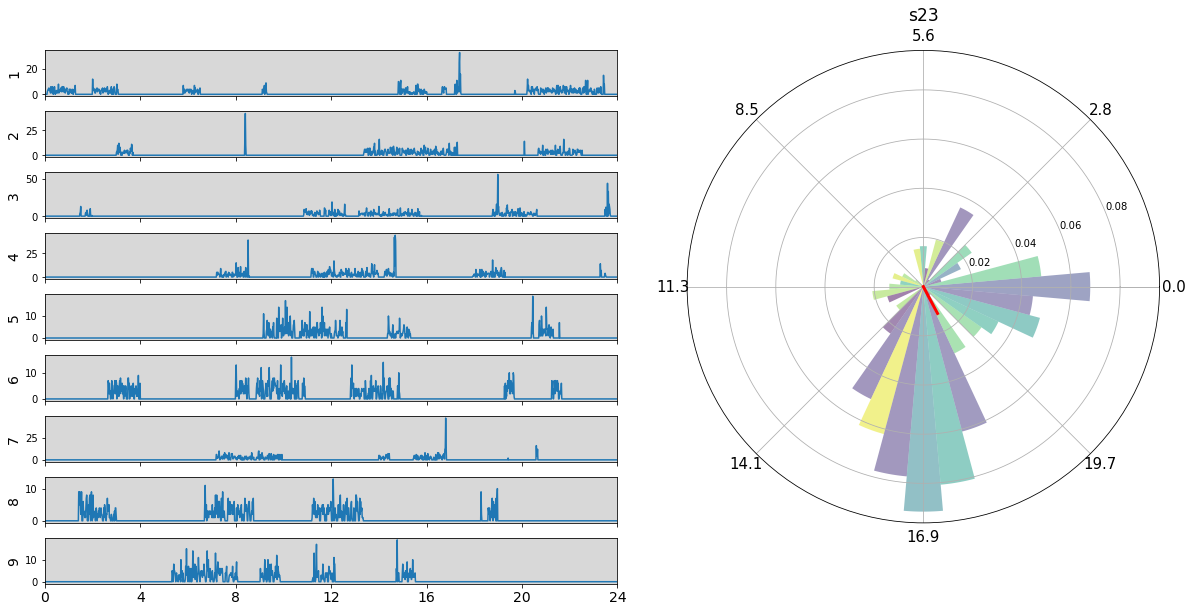

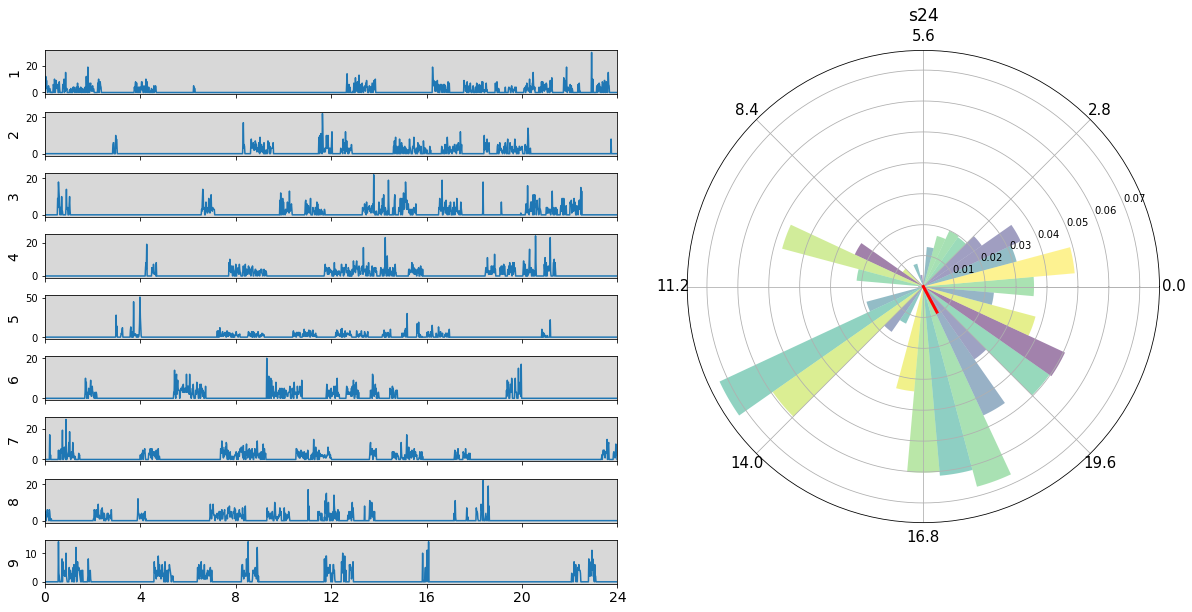

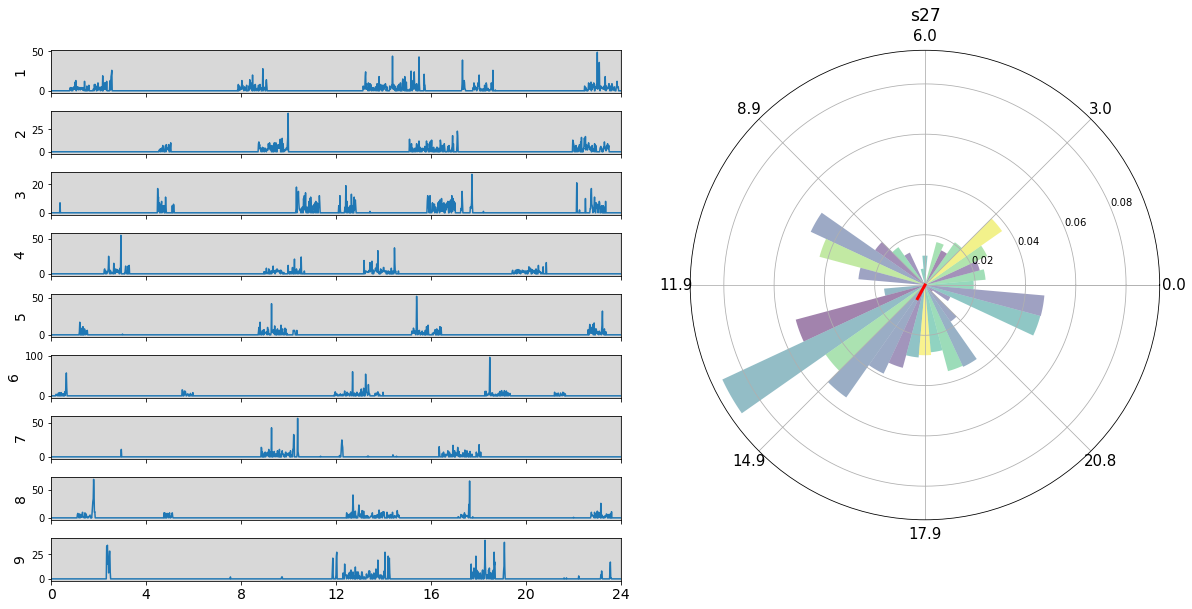

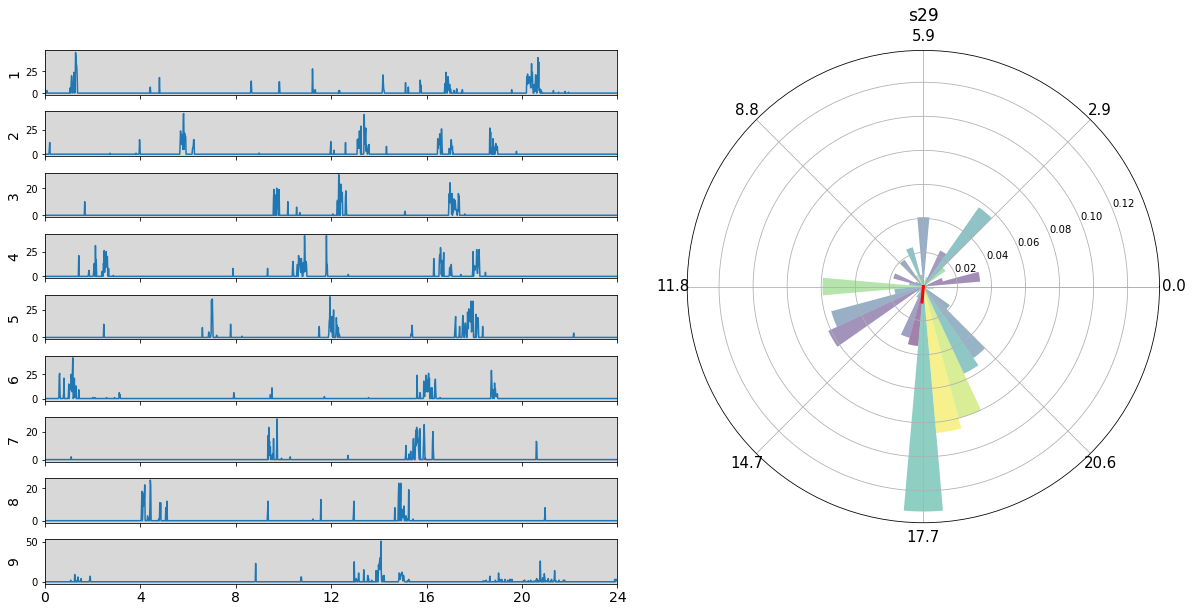

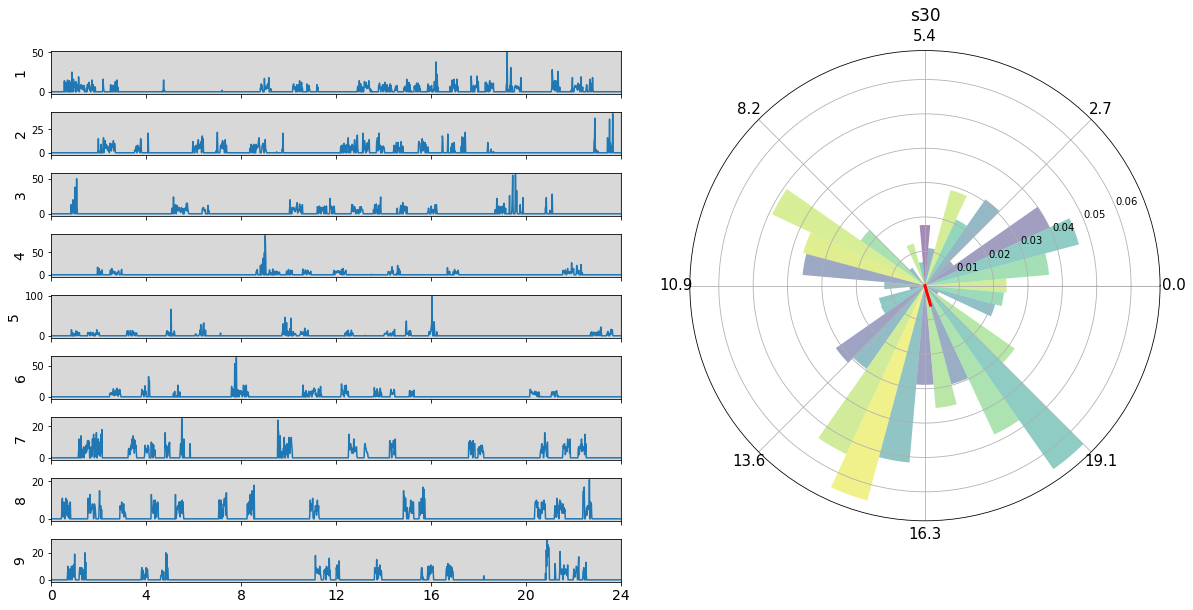

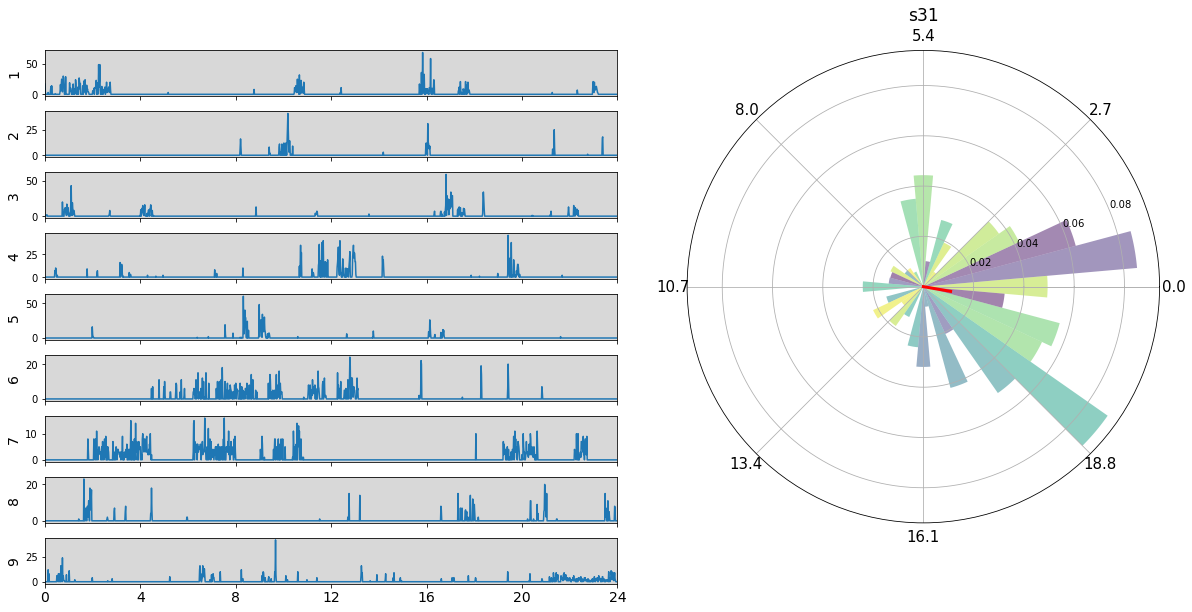

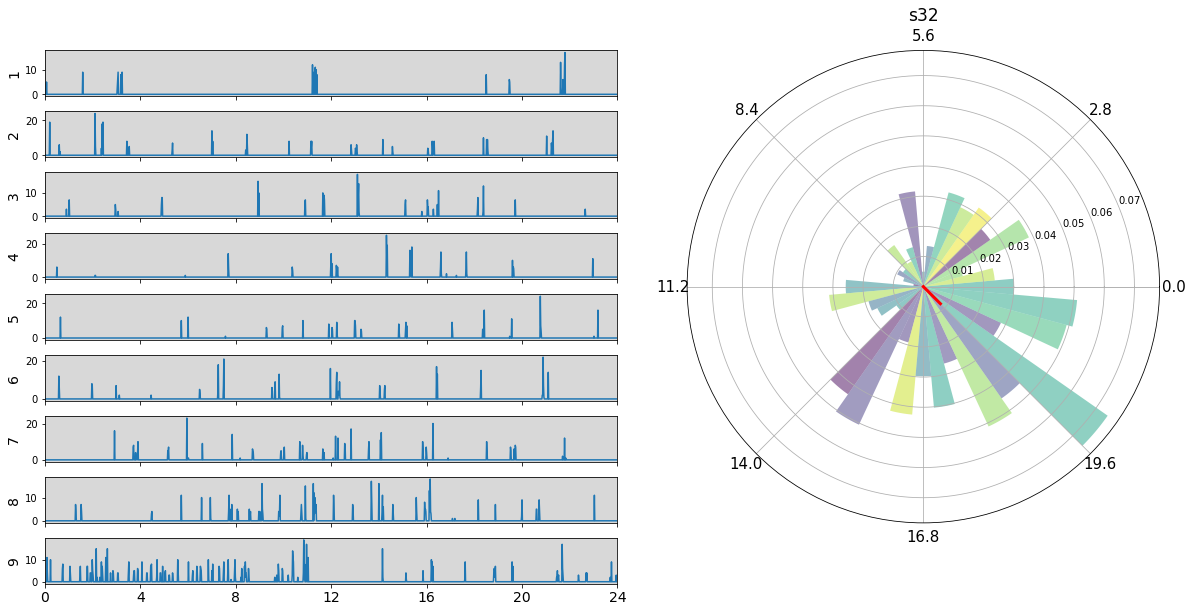

In [20]:
#Data file name containing the activity data to be analyzed
file_name='Para_DD.csv'

#md_dd: mean direction of each spider in DD period
#r_dd: r value of each spider in DD period
#periodlist: circadian period of each spider calculated by periodogram in DD period
md_dd=[]
r_dd=[]
periodlist=[]
for spider in s:
    #Only use spiders whose DD period calculated by periodogram is statistically significant at the level of 0.001
     if df_period.loc[spider, 'p value']<=0.001:
        period=df_period.loc[spider, 'Period']
        obj=Circular(nbins=36)
        #For DD, the circadian period is calculated by periodogram
        obj.run(file_name, spider, period)
        obj.run_plot(spider)
        #Save the mean direction, r value, and circadian period in the lists
        md_dd.append(obj.theta_avg)
        r_dd.append(obj.r_total)
        periodlist.append(obj.period)

### Save the circular statistics for each spider in .csv file

In [21]:
#Output file name
output_filename_DD='Mean_Para_DD.csv'

#Save the mean direction and r value (mean length) in a dataframe
para_dd=pd.DataFrame({'Mean Direction': md_dd, 'Mean Length': r_dd}, index=df_period[df_period['p value']<=0.001].index)
#Save as a .csv file
para_dd.to_csv(output_filename_DD)
para_dd.head()

Mean Direction  Mean Length
Spider                             
s1          -61.179577     0.361320
s2          -77.201016     0.518696
s3           -1.752357     0.436463
s4          -70.201855     0.403891
s6          -14.414561     0.184253